In [1]:
#imports
import nibabel as nib
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

from scipy.ndimage import gaussian_filter

In [2]:
import tensorflow as tf

import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate
#from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import CSVLogger
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import models, layers, regularizers

#from focal_loss import BinaryFocalLoss

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


# Input brain MRI images path

In [4]:
TRAIN_DATASET_PATH = 'C:\\Users\\Anita\\Datasets\\ISLES2022\\Training\\rawdata'
train_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
#len(train_directories)
train_directories
train_ids = []
for i in range(len(train_directories)):
    train_ids.append(train_directories[i][51:69])
len(train_ids)

250

# Ground Truth/Mask brain MRI path

In [5]:
TRAINMask_DATASET_PATH = 'C:\\Users\\Anita\\Datasets\\ISLES2022\\Training\\derivatives'
mask_directories = [f.path for f in os.scandir(TRAINMask_DATASET_PATH) if f.is_dir()]
mask_directories
len(mask_directories)

mask_ids = []
for i in range(len(mask_directories)):
    mask_ids.append(mask_directories[i][55:73])
len(mask_ids)

250

# Split the dataset into Train, valid and test

In [6]:
from sklearn.model_selection import train_test_split
train_val_ids, test_ids,train_val_mask, test_mask = train_test_split(train_ids,mask_ids,test_size=0.20,random_state=42) 
train_ids,  val_ids, train_mask , val_mask = train_test_split(train_val_ids,train_val_mask,test_size=0.20,random_state=42)
len(train_ids)

160

In [7]:
print('trainingId:',len(train_ids))
print('val_Id:',len(val_ids))
print('Test_Id:',len(test_ids))

trainingId: 160
val_Id: 40
Test_Id: 50


In [8]:
len(test_ids)
test_ids

['sub-strokecase0143',
 'sub-strokecase0007',
 'sub-strokecase0098',
 'sub-strokecase0061',
 'sub-strokecase0113',
 'sub-strokecase0182',
 'sub-strokecase0198',
 'sub-strokecase0185',
 'sub-strokecase0010',
 'sub-strokecase0105',
 'sub-strokecase0201',
 'sub-strokecase0217',
 'sub-strokecase0237',
 'sub-strokecase0241',
 'sub-strokecase0068',
 'sub-strokecase0225',
 'sub-strokecase0195',
 'sub-strokecase0016',
 'sub-strokecase0178',
 'sub-strokecase0025',
 'sub-strokecase0248',
 'sub-strokecase0020',
 'sub-strokecase0115',
 'sub-strokecase0069',
 'sub-strokecase0177',
 'sub-strokecase0046',
 'sub-strokecase0056',
 'sub-strokecase0011',
 'sub-strokecase0031',
 'sub-strokecase0121',
 'sub-strokecase0202',
 'sub-strokecase0034',
 'sub-strokecase0142',
 'sub-strokecase0220',
 'sub-strokecase0026',
 'sub-strokecase0112',
 'sub-strokecase0019',
 'sub-strokecase0197',
 'sub-strokecase0181',
 'sub-strokecase0160',
 'sub-strokecase0119',
 'sub-strokecase0097',
 'sub-strokecase0109',
 'sub-strok

# Performance metrics/Loss function

In [9]:
# defining the performance metrics
def dice_coeff(y_true,y_pred):
    # Perform the conditional operation using TensorFlow
    # Set values less than 2.2 to 0
    #y_pred = tf.where(y_pred < 0.2, tf.zeros_like(y_pred), y_pred)
    y_true_new = K.flatten(y_true)
    y_pred_new = K.flatten(y_pred)
    denominator = K.sum(y_true_new) + K.sum(y_pred_new)
    if denominator == 0.0:
        return 1.0
    numerator = K.sum(y_true_new * y_pred_new)
    return (2.0*numerator)/(denominator)

def dice_coeff_loss(y_true,y_pred):
    return 1.0- dice_coeff(y_true,y_pred)

def iou(y_true,y_pred):
    #y_pred = tf.where(y_pred < 0.2, tf.zeros_like(y_pred), y_pred)
    intersec = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    if union == 0.0:
        return 1.0
    iou = (intersec) / (union- intersec)
    return iou

def dice_score(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + 1e-5) / (union + 1e-5)
    return dice

def dice_loss(y_true, y_pred):
    return 1.0 -dice_score(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_coeff_loss(y_true, y_pred)
    return loss

def ce_dice_loss(y_true, y_pred):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred) + dice_coeff_loss(y_true, y_pred)
    return loss

In [10]:
def precision_score_(y_true, y_pred):
    y_true_new = K.flatten(y_true)
    y_pred_new = K.flatten(y_pred)
    intersect = K.sum(y_pred_new*y_true_new)
    total_pixel_pred = K.sum(y_pred_new)
    #precision = intersect/total_pixel_pred
    return intersect/total_pixel_pred

def recall_score_(y_true, y_pred):
    y_true_new = K.flatten(y_true)
    y_pred_new = K.flatten(y_pred)
    intersect = K.sum(y_pred_new*y_true_new)
    total_pixel_truth = K.sum(y_true_new)
    #recall = np.mean(intersect/total_pixel_truth)
    return intersect/total_pixel_truth


# Input image pipeline for model/Preprocessing

In [11]:
#VOLUME_SLICES = 20
#VOLUME_START_AT = 5
IMG_SIZE=112

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 1, shuffle=False):
       
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        Batch_ids = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        
        # Generate data
        for c, i in enumerate(Batch_ids):        
            case_path = os.path.join(TRAIN_DATASET_PATH, i)
            data_path = os.path.join(case_path + '/ses-0001', f'{i}_ses-0001_dwi.nii.gz');
            dwi = nib.load(data_path).get_fdata()
            
            dwi=scaler.fit_transform(dwi.reshape(-1, dwi.shape[-1])).reshape(dwi.shape)
            #adc=scaler.fit_transform(adc.reshape(-1, adc.shape[-1])).reshape(adc.shape)
            slices = dwi.shape[2]
            X = np.zeros((slices, IMG_SIZE,IMG_SIZE, 1))

            case_path2 = os.path.join(TRAINMask_DATASET_PATH, i)
            data_path_2 = os.path.join(case_path2 + '/ses-0001', f'{i}_ses-0001_msk.nii.gz');
            msk = nib.load(data_path_2).get_fdata()
            #msk=msk.astype(np.float32)
            msk_slices = msk.shape[2]
            y = np.zeros((msk_slices, IMG_SIZE,IMG_SIZE))
            #print(msk.dtype)  

            
            for j in range(slices):
                X[j,:,:,0] = cv2.resize(dwi[:,:,j+0], (IMG_SIZE, IMG_SIZE));
                X=X.astype(np.float32)
                
                y[j] = cv2.resize(msk[:,:,j+0],(IMG_SIZE,IMG_SIZE));
                
                # Apply thresholding to convert back to binary values
                threshold = 0.1  # Adjust this threshold as needed
                binary_mask = np.where(y >= threshold, 1, 0).astype(np.float32)
                
 
        return X, binary_mask
        
training_generator = DataGenerator(train_ids)
val_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [12]:
len(training_generator)
#training_generator[0]

160

# Unet model

In [13]:
import tensorflow as tf

from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Input, BatchNormalization, Activation

def unet_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def attention_block(l_layer,h_layer): #Attention Block
    phi=Conv2D(h_layer.shape[-1],(1,1),padding='same')(l_layer)
    theta=Conv2D(h_layer.shape[-1],(1,1),strides=(2,2),padding='same')(h_layer)
    x=tf.keras.layers.add([phi,theta])
    x=Activation('relu')(x)
    x=Conv2D(1,(1,1),padding='same',activation='sigmoid')(x)
    x=UpSampling2D(size=(2,2))(x)
    x=tf.keras.layers.multiply([h_layer,x])
    x=BatchNormalization(axis=3)(x)
    return x

def Attention_UNet(input_shape=(112, 112, 1), num_classes=1):
    inputs = Input(input_shape)
    features = 16

    # Encoder
    enc1 = unet_block(inputs, features)
    pool1 = MaxPooling2D(pool_size=(2, 2))(enc1)
    
    enc2 = unet_block(pool1, features * 2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(enc2)
    
    enc3 = unet_block(pool2, features * 4)
    pool3 = MaxPooling2D(pool_size=(2, 2))(enc3)
    
    enc4 = unet_block(pool3, features * 8)
    pool4 = MaxPooling2D(pool_size=(2, 2))(enc4)

    # Bottleneck
    bottleneck = unet_block(pool4, features * 16)

    # Decoder
    upconv4 = Conv2DTranspose(features * 8, (2, 2), strides=(2, 2), padding="same")(bottleneck)
    #dec4=attention_block(bottleneck,enc4) #Attention Gate
    dec4 = concatenate([upconv4, enc4])
    dec4 = unet_block(dec4, features * 8)
    
    upconv3 = Conv2DTranspose(features * 4, (2, 2), strides=(2, 2), padding="same")(dec4)#(enc4)#(dec4)
    #dec3 = attention_block(dec4,enc3)
    dec3 = concatenate([upconv3, enc3])
    dec3 = unet_block(dec3, features * 4)
    
    upconv2 = Conv2DTranspose(features * 2, (2, 2), strides=(2, 2), padding="same")(dec3)
    #dec2 = attention_block(dec3,enc2) #Attention Gate
    dec2 = concatenate([upconv2, enc2]) 
    dec2 = unet_block(dec2, features * 2)
    
    upconv1 = Conv2DTranspose(features, (2, 2), strides=(2, 2), padding="same")(dec2)
    #dec1 = attention_block(dec2,enc1) #Attention Gate
    dec1 = concatenate([upconv1, enc1])
    dec1 = unet_block(dec1, features)

    outputs = Conv2D(num_classes, (1, 1), activation="sigmoid")(dec1)

    return Model(inputs, outputs)

# Create the model
model = Attention_UNet(input_shape=(112, 112, 1), num_classes=1)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_9 (BatchNo  (None, 7, 7, 256)   1024        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 7, 7, 256)    0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 14, 14, 128)  131200     ['activation_9[0][0]']           
 ose)                                                                                             
                                                                                                  
 concatenate (Concatenate)      (None, 14, 14, 256)  0           ['conv2d_transpose[0][0]',       
                                                                  'activation_7[0][0]']           
          

 batch_normalization_17 (BatchN  (None, 112, 112, 16  64         ['conv2d_17[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_17 (Activation)     (None, 112, 112, 16  0           ['batch_normalization_17[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 112, 112, 1)  17          ['activation_17[0][0]']          
                                                                                                  
Total params: 1,946,705
Trainable params: 1,943,761
Non-trainable params: 2,944
__________________________________________________________________________________________________


# Compile the model with Dice loss function

In [14]:
model.compile(loss=dice_coeff_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy', dice_coeff,iou] )


# Train the model

In [15]:
#from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('ISLES22_Attention_Unet.h5', monitor='val_loss',verbose=1, save_best_only=True, mode='min')
#early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
att_unet_history = model.fit(training_generator, 
                    #steps_per_epoch=len(train_ids),
                    validation_data=val_generator, 
                    callbacks= [checkpoint],
                    epochs=100)

Epoch 1/100
160/160 [==============================] - ETA: 0s - loss: 0.9741 - accuracy: 0.8814 - dice_coeff: 0.0279 - iou: 0.0147
Epoch 1: val_loss improved from inf to 0.98768, saving model to ISLES22_Attention_Unet.h5
160/160 [==============================] - 85s 507ms/step - loss: 0.9741 - accuracy: 0.8814 - dice_coeff: 0.0279 - iou: 0.0147 - val_loss: 0.9877 - val_accuracy: 0.8499 - val_dice_coeff: 0.0134 - val_iou: 0.0069
Epoch 2/100
160/160 [==============================] - ETA: 0s - loss: 0.8995 - accuracy: 0.9786 - dice_coeff: 0.1118 - iou: 0.0660
Epoch 2: val_loss improved from 0.98768 to 0.98043, saving model to ISLES22_Attention_Unet.h5
160/160 [==============================] - 79s 494ms/step - loss: 0.8995 - accuracy: 0.9786 - dice_coeff: 0.1118 - iou: 0.0660 - val_loss: 0.9804 - val_accuracy: 0.9749 - val_dice_coeff: 0.0212 - val_iou: 0.0109
Epoch 3/100
160/160 [==============================] - ETA: 0s - loss: 0.7280 - accuracy: 0.9956 - dice_coeff: 0.2979 - iou: 0.2

160/160 [==============================] - ETA: 0s - loss: 0.3058 - accuracy: 0.9983 - dice_coeff: 0.7115 - iou: 0.5833
Epoch 41: val_loss did not improve from 0.31962
160/160 [==============================] - 81s 508ms/step - loss: 0.3058 - accuracy: 0.9983 - dice_coeff: 0.7115 - iou: 0.5833 - val_loss: 0.3676 - val_accuracy: 0.9985 - val_dice_coeff: 0.6511 - val_iou: 0.5384
Epoch 42/100
160/160 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.9983 - dice_coeff: 0.7162 - iou: 0.5872
Epoch 42: val_loss did not improve from 0.31962
160/160 [==============================] - 80s 495ms/step - loss: 0.3021 - accuracy: 0.9983 - dice_coeff: 0.7162 - iou: 0.5872 - val_loss: 0.3933 - val_accuracy: 0.9981 - val_dice_coeff: 0.6307 - val_iou: 0.5015
Epoch 43/100
160/160 [==============================] - ETA: 0s - loss: 0.2986 - accuracy: 0.9983 - dice_coeff: 0.7197 - iou: 0.5926
Epoch 43: val_loss did not improve from 0.31962
160/160 [==============================] - 81s

Epoch 62/100
160/160 [==============================] - ETA: 0s - loss: 0.2588 - accuracy: 0.9985 - dice_coeff: 0.7546 - iou: 0.6330
Epoch 62: val_loss did not improve from 0.31962
160/160 [==============================] - 61s 383ms/step - loss: 0.2588 - accuracy: 0.9985 - dice_coeff: 0.7546 - iou: 0.6330 - val_loss: 0.3962 - val_accuracy: 0.9978 - val_dice_coeff: 0.6169 - val_iou: 0.4888
Epoch 63/100
160/160 [==============================] - ETA: 0s - loss: 0.2625 - accuracy: 0.9984 - dice_coeff: 0.7513 - iou: 0.6298
Epoch 63: val_loss did not improve from 0.31962
160/160 [==============================] - 82s 504ms/step - loss: 0.2625 - accuracy: 0.9984 - dice_coeff: 0.7513 - iou: 0.6298 - val_loss: 0.3322 - val_accuracy: 0.9986 - val_dice_coeff: 0.6823 - val_iou: 0.5655
Epoch 64/100
160/160 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.9985 - dice_coeff: 0.7652 - iou: 0.6471
Epoch 64: val_loss did not improve from 0.31962
160/160 [========================

Epoch 83/100
160/160 [==============================] - ETA: 0s - loss: 0.2467 - accuracy: 0.9986 - dice_coeff: 0.7667 - iou: 0.6481
Epoch 83: val_loss did not improve from 0.29732
160/160 [==============================] - 84s 523ms/step - loss: 0.2467 - accuracy: 0.9986 - dice_coeff: 0.7667 - iou: 0.6481 - val_loss: 0.6838 - val_accuracy: 0.9948 - val_dice_coeff: 0.3314 - val_iou: 0.2306
Epoch 84/100
160/160 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.9986 - dice_coeff: 0.7814 - iou: 0.6678
Epoch 84: val_loss did not improve from 0.29732
160/160 [==============================] - 62s 392ms/step - loss: 0.2305 - accuracy: 0.9986 - dice_coeff: 0.7814 - iou: 0.6678 - val_loss: 0.3340 - val_accuracy: 0.9986 - val_dice_coeff: 0.6810 - val_iou: 0.5687
Epoch 85/100
160/160 [==============================] - ETA: 0s - loss: 0.2370 - accuracy: 0.9986 - dice_coeff: 0.7755 - iou: 0.6592
Epoch 85: val_loss did not improve from 0.29732
160/160 [========================

In [16]:
# Load the saved weights
#model.load_weights('DiceLoss_ISLES22_AGUNET_32M.h5')

# Test the model

In [16]:
test_pred=model.predict(test_generator)

50/50 [==============================] - 20s 385ms/step


In [17]:
import tensorflow as tf

def hausdorff_distance(y_true, y_pred,threshold=0.5):
    # Threshold the probability map to obtain binary predictions
    y_pred = tf.cast(tf.greater(y_pred, threshold), dtype=tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    # Get the coordinates of non-zero pixels in both masks
    true_coords = tf.where(tf.not_equal(y_true, 0))
    pred_coords = tf.where(tf.not_equal(y_pred, 0))
    
    # Debugging: print shapes
    #tf.print("true_coords shape:", tf.shape(true_coords))
    #tf.print("pred_coords shape:", tf.shape(pred_coords))
    
    if tf.size(true_coords) == 0 and tf.size(pred_coords) == 0:
        return tf.constant(0.0, dtype=tf.float32)  # No foreground in both masks, distance is zero
    if tf.size(true_coords) == 0 or tf.size(pred_coords) == 0:
        return tf.constant(float('inf'), dtype=tf.float32)  # One mask is empty, the other is not
    
    
    
    # Calculate pairwise Euclidean distances
    true_coords_expanded = tf.expand_dims(true_coords, 1)
    pred_coords_expanded = tf.expand_dims(pred_coords, 0)
    #pred_coords_expanded = tf.transpose(pred_coords_expanded, perm=[1,0,2])
    
    # Debugging: print expanded shapes
    #tf.print("true_coords_expanded shape:", tf.shape(true_coords_expanded))
    #tf.print("pred_coords_expanded shape:", tf.shape(pred_coords_expanded))
    # Ensure expanded coordinates are cast to float32
    true_coords_expanded = tf.cast(true_coords_expanded, tf.float32)
    pred_coords_expanded = tf.cast(pred_coords_expanded, tf.float32)
    distances = tf.sqrt(tf.reduce_sum(tf.square(true_coords_expanded - pred_coords_expanded), axis=2))

    # Calculate the Hausdorff Distance using the maximum distance
    hd_distance = tf.reduce_max(tf.reduce_min(distances, axis=1), axis=0)
    # Debugging: print the final distance
    #tf.print("Hausdorff distance:", hd_distance)

    return hd_distance

# Function to compute the Dice coefficient
def dice_coeff(y_true,y_pred):
    # Ensure both tensors are of type float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_new = K.flatten(y_true)
    y_pred_new = K.flatten(y_pred)
    denominator = K.sum(y_true_new) + K.sum(y_pred_new)
    if denominator == 0.0:
        return 1.0
    numerator = K.sum(y_true_new * y_pred_new)
    return (2.0*numerator)/(denominator)

def iou(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersec = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    if union == 0.0:
        return 1.0
    iou = (intersec) / (union- intersec)
    return iou

# Function to compute Precision
def precision(y_true, y_pred):
    y_true_f = np.ravel(y_true)
    y_pred_f = np.ravel(y_pred)
    true_positives = np.sum(y_true_f * y_pred_f)
    predicted_positives = np.sum(y_pred_f)
    return (true_positives) / (predicted_positives)

# Function to compute Recall
def recall(y_true, y_pred):
    y_true_f = np.ravel(y_true)
    y_pred_f = np.ravel(y_pred)
    true_positives = np.sum(y_true_f * y_pred_f)
    possible_positives = np.sum(y_true_f)
    return (true_positives) / (possible_positives)

def precision_score_(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_new = K.flatten(y_true)
    y_pred_new = K.flatten(y_pred)
    intersect = K.sum(y_pred_new*y_true_new)
    total_pixel_pred = K.sum(y_pred_new)
    if total_pixel_pred == 0.0:
        return 1.0
    #precision = intersect/total_pixel_pred
    return intersect/total_pixel_pred

def recall_score_(y_true, y_pred):
    #y_pred = tf.where(y_pred < 0.2, tf.zeros_like(y_pred), y_pred)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_new = K.flatten(y_true)
    y_pred_new = K.flatten(y_pred)
    intersect = K.sum(y_pred_new*y_true_new)
    total_pixel_truth = K.sum(y_true_new)
    if total_pixel_truth == 0.0:
        return 1.0
    #recall = np.mean(intersect/total_pixel_truth)
    return intersect/total_pixel_truth


# Initialize lists to store loss and metric values
loss_values = []
dice_values = []
iou_values = []
precision_values = []
recall_values = []
hausdorff_distance_value = []

# Loop through the test generator
for batch_x, batch_y in test_generator:
    # Predict the output for the batch
    #print(batch_y.shape)
    mask_image = np.expand_dims(batch_y, axis=-1)
    y_predwts = model.predict(batch_x)
    #y_predwt = y_predwts
    #print('y_pred',y_predwts.shape)
    #y_pred_thresholded = np.where(y_predwts >= 0.5, 1.0, 0.0).astype(np.float32)#binary
    y_pred = np.where(y_predwts < 0.2, 0.0, y_predwts).astype(np.float32)#relu
    y_pred_thresholded = y_pred 
    
    # Loop through each sample in the batch
    for i in range(len(batch_x)):
        # Compute the loss and metrics for each sample
        #loss = compute_loss(batch_y[i], y_pred[i])
        dice = dice_coeff(batch_y[i], y_pred_thresholded[i])
        iou_value = iou(batch_y[i], y_pred_thresholded[i])
        precision_value = precision_score_(batch_y[i], y_pred_thresholded[i])
        recall_value = recall_score_(batch_y[i], y_pred_thresholded[i])
        Hausdorff_Distance = hausdorff_distance(mask_image[i], y_predwts[i])
        
        # Store the computed values
        #loss_values.append(loss)
        dice_values.append(dice)
        iou_values.append(iou_value)
        precision_values.append(precision_value)
        recall_values.append(recall_value)
        hausdorff_distance_value.append(Hausdorff_Distance)
    
    # Stop if we've processed all steps
    if len(loss_values) >= len(test_generator):
        break

# Compute the average loss and metrics
#average_loss = np.mean(loss_values)
average_dice = np.mean(dice_values)
average_iou = np.mean(iou_values)
average_precision = np.mean(precision_values)
average_recall = np.mean(recall_values)
#average_hausdorff_distance_value = np.mean(hausdorff_distance_value)
# Convert the list to a tensor for easy aggregation
hd_distances = tf.stack(hausdorff_distance_value)
#Exclude slices with inf values from the calculation
valid_hd_distances = tf.boolean_mask(hd_distances, tf.math.is_finite(hd_distances))
mean_hd = tf.reduce_mean(valid_hd_distances)
max_hd = tf.reduce_max(valid_hd_distances)

#print("Average test loss: ", average_loss)
print("Average test dice: ", average_dice)
print("Average test IoU: ", average_iou)
print("Average test precision: ", average_precision)
print("Average test recall: ", average_recall)
print("Average test hausdorff_distance: ", mean_hd)
print("Max test hausdorff_distance: ", max_hd)


3/3 [==============================] - 0s 7ms/step
Average test dice:  0.6292497452279467
Average test IoU:  0.6023466020682403
Average test precision:  0.6698904128981238
Average test recall:  0.9030170340655852
Average test hausdorff_distance:  tf.Tensor(2.43894, shape=(), dtype=float32)
Max test hausdorff_distance:  tf.Tensor(57.280014, shape=(), dtype=float32)


In [18]:
# paths.
isles_data_dir = 'C:\\Users\\Anita\\Datasets\\ISLES2022\\Training/'
example_case = 129 #196 #229 #41 #78

# Set images path.
dwi_path = os.path.join(isles_data_dir, 'rawdata', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001',
                    'sub-strokecase{}_ses-0001_dwi.nii.gz'.format("%04d" % example_case))
adc_path = dwi_path.replace('dwi', 'adc')
flair_path = dwi_path.replace('dwi', 'flair')
mask_path = dwi_path.replace('rawdata', 'derivatives').replace('dwi', 'msk')

# Load image data.
dwi_image = nib.load(dwi_path).get_fdata()
adc_image = nib.load(adc_path).get_fdata()
flair_image = nib.load(flair_path).get_fdata()
mask_image = nib.load(mask_path).get_fdata()
dwi_image=scaler.fit_transform(dwi_image.reshape(-1, dwi_image.shape[-1])).reshape(dwi_image.shape)
dwi_image=cv2.resize(dwi_image[:,:],(112,112))
dwi_image.shape
mask_image=cv2.resize(mask_image[:,:],(112,112))
mask_image.shape

(112, 112, 73)

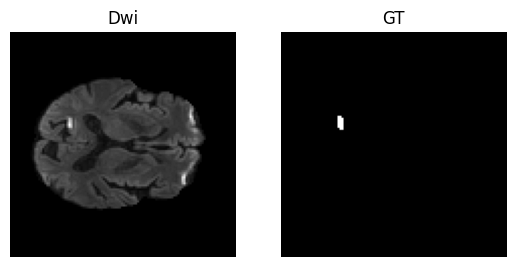

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2)

slice2show=40
ax1.imshow(dwi_image[:,:,slice2show], cmap='gray')
ax1.set_title('Dwi')
ax1.set_axis_off()


# Show DWI image w/overlayed mask.
ax2.imshow(mask_image[:,:,slice2show], cmap='gray')
#ax2.imshow(mask_image[:,:,slice2show], alpha=0.5, cmap='copper')
ax2.set_title('GT')
ax2.set_axis_off()

3/3 [==============================] - 0s 7ms/step


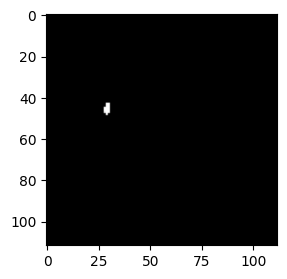

In [22]:
X = np.zeros((73,112,112,1))
for j in range(73):
    X[j,:,:,0] =dwi_image[:,:,j]
X.shape

pred_wt=model.predict(X)
fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.imshow(pred_wt[40,:,:,:],cmap='gray')

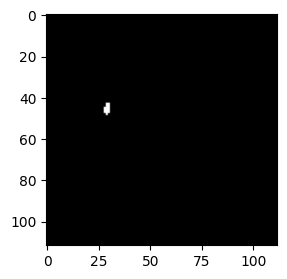

In [23]:
y_pred_thresholded = pred_wt > 0.2
#dice loss
fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.imshow(y_pred_thresholded[40,:,:,:],cmap='gray')

In [24]:
def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    total = np.sum(y_true) + np.sum(y_pred)
    if total == 0:
        return 1.0
    dice = (2.0 * intersection) / (total)  # Adding a small epsilon to avoid division by zero
    dice = round(dice, 3)
    return dice

def iou(y_true,y_pred):
    intersec = np.sum(y_true * y_pred)
    union = np.sum(y_true + y_pred)
    if union == 0:
        return 1.0
    iou = (intersec) / (union- intersec)
    iou = round(iou, 3)
    return iou

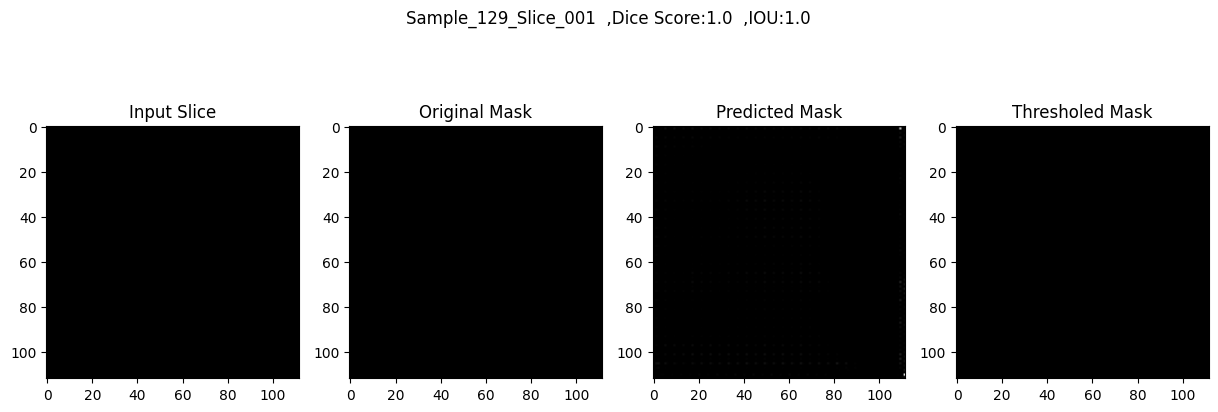

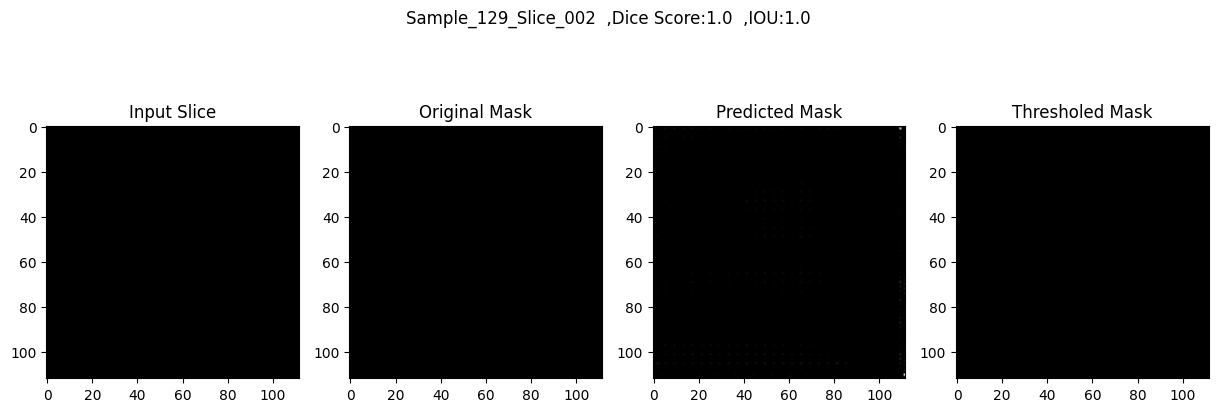

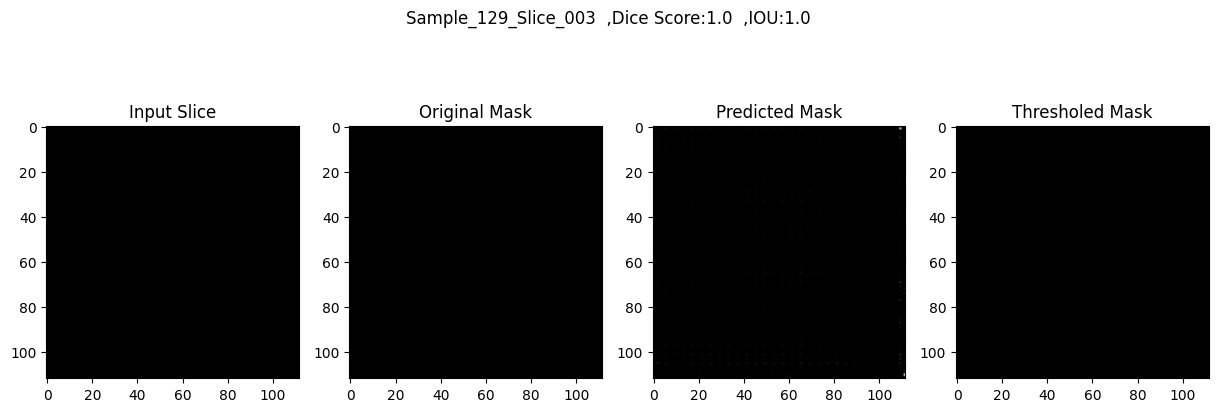

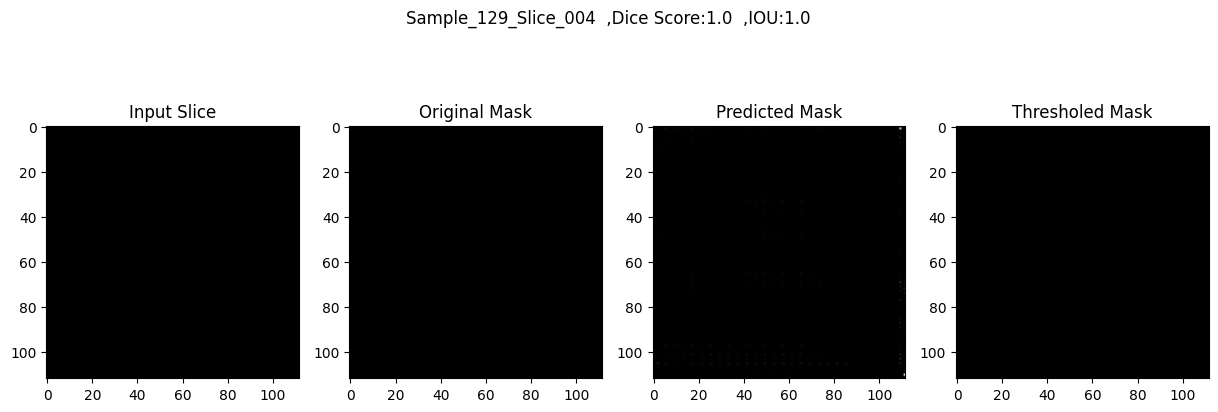

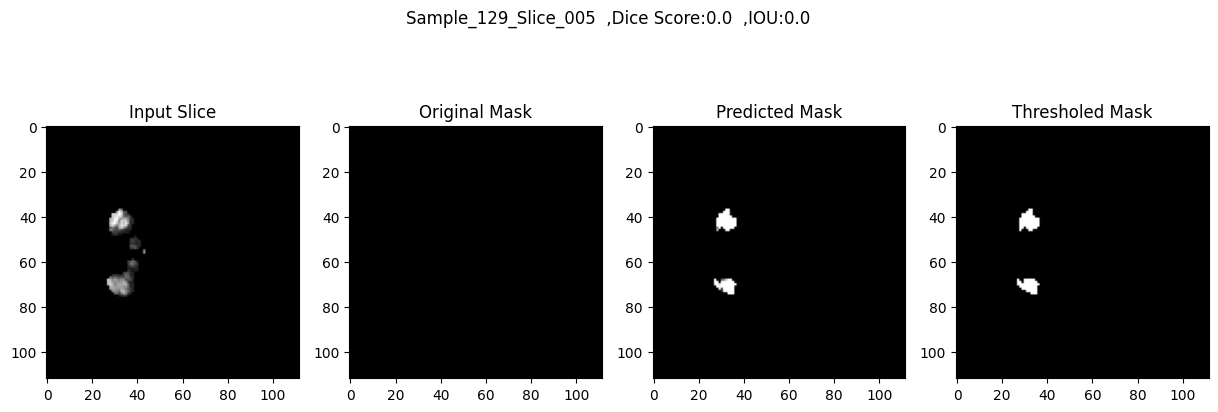

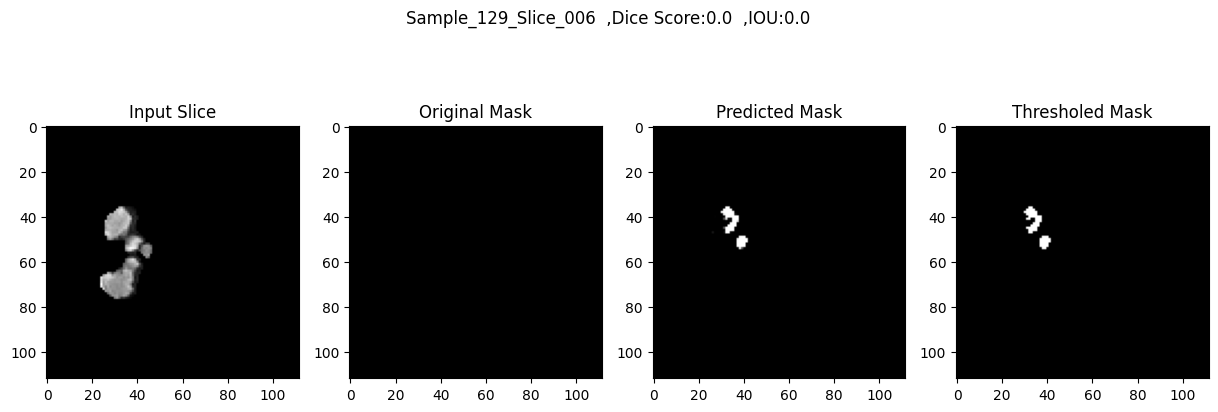

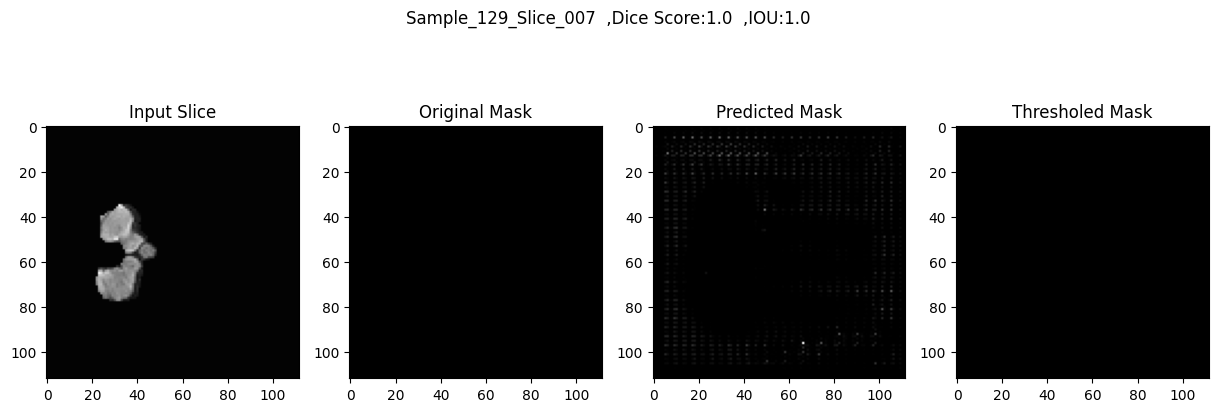

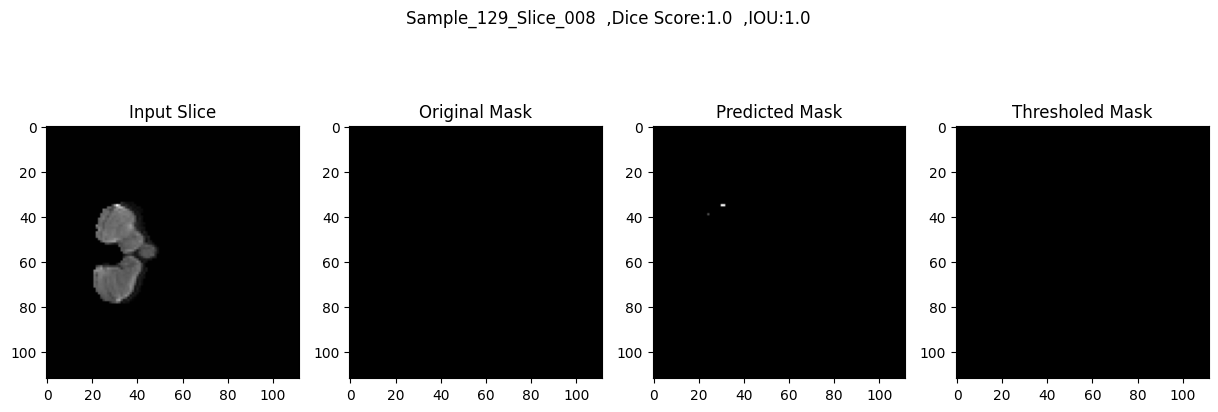

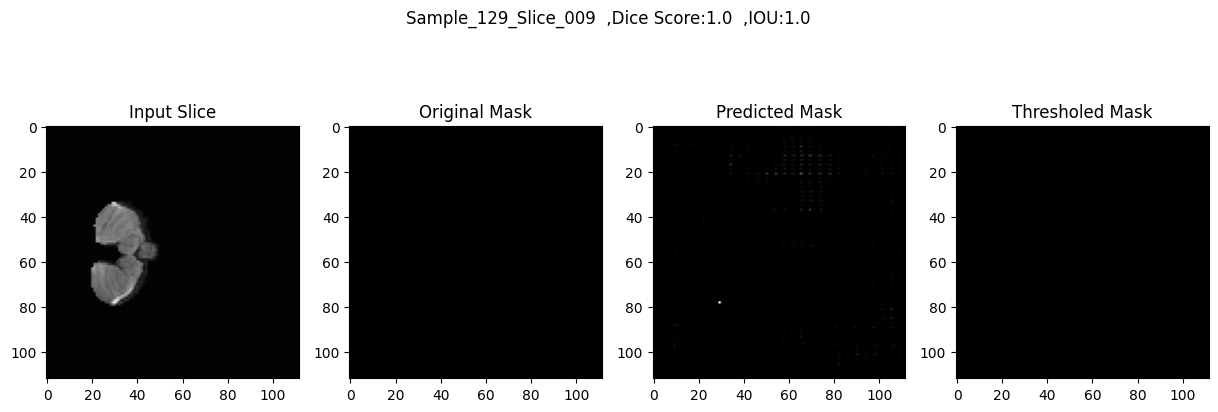

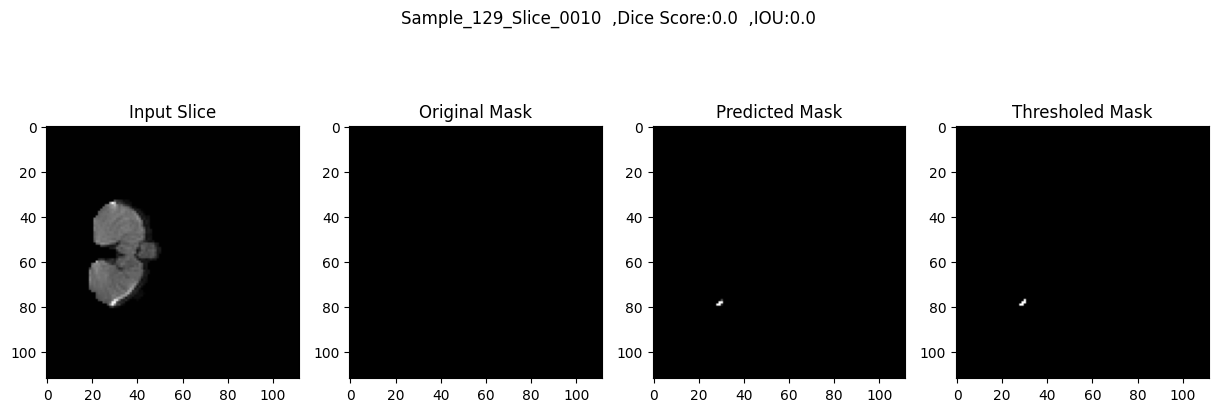

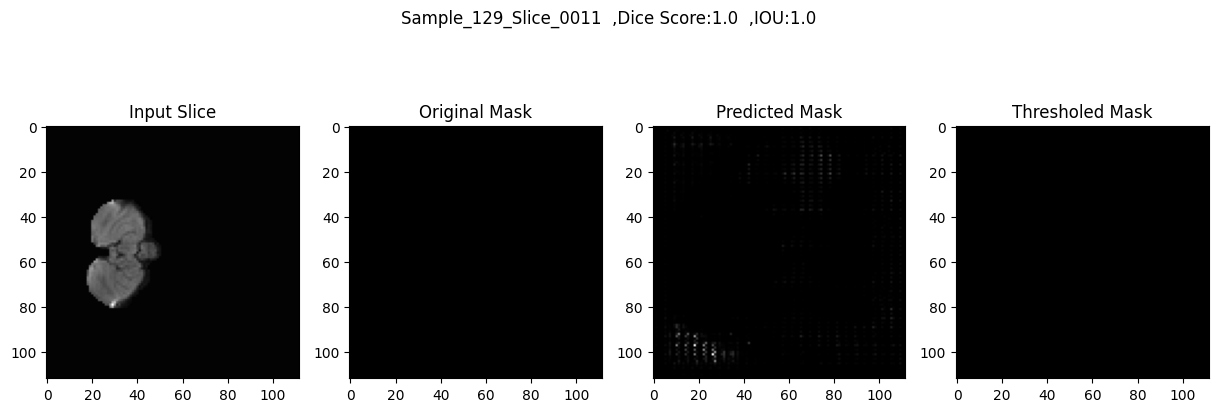

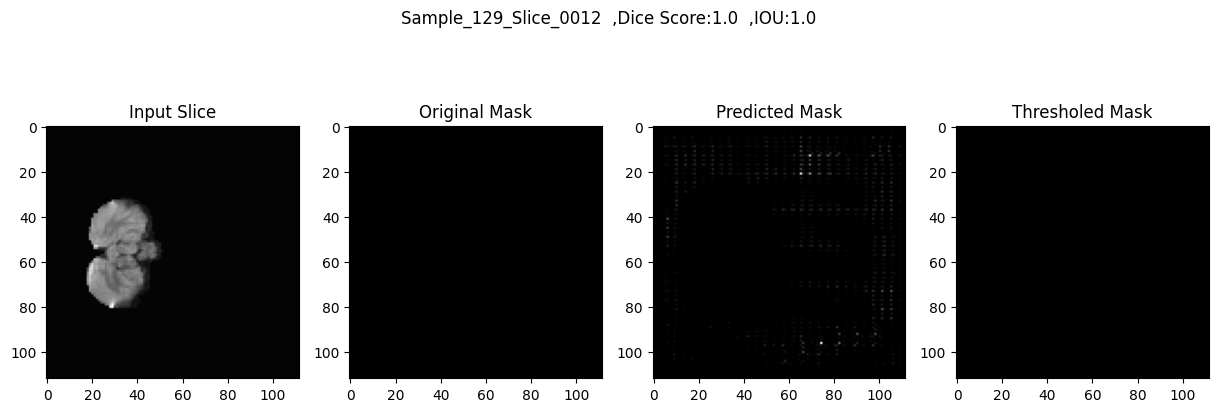

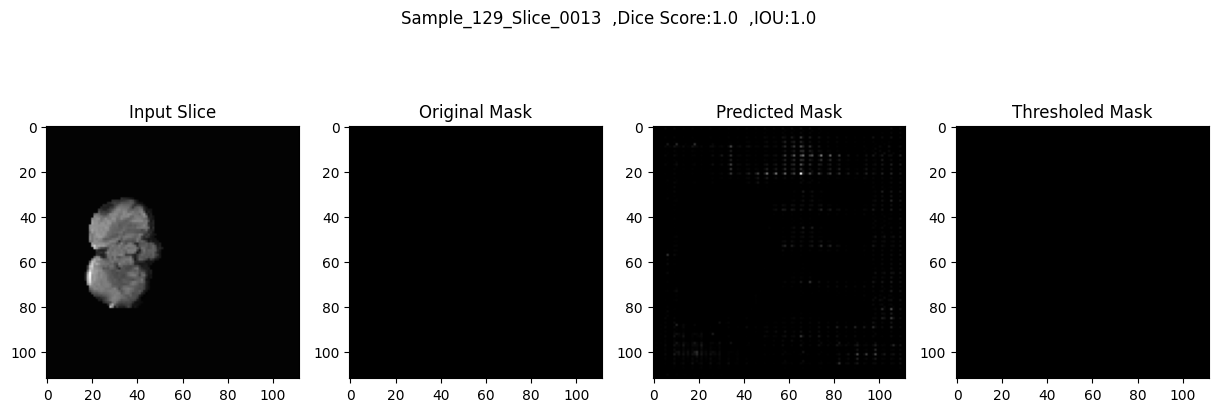

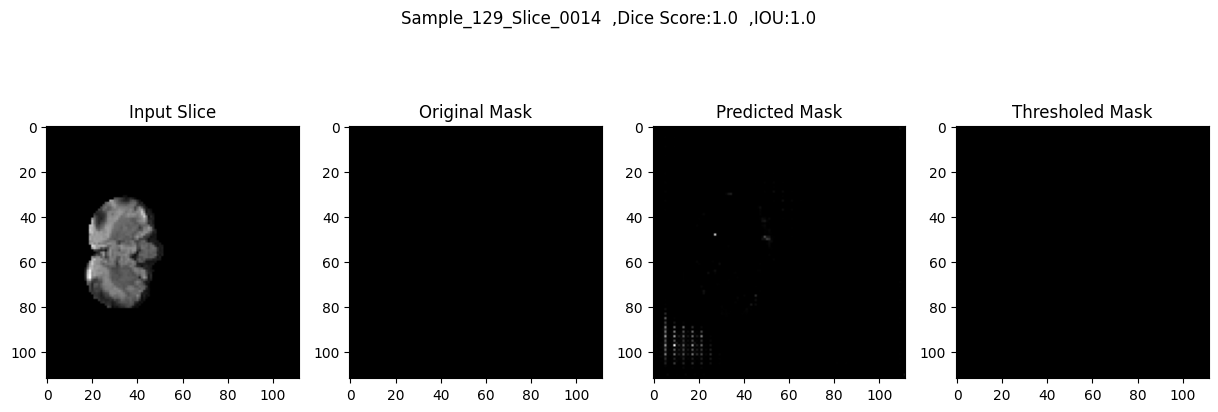

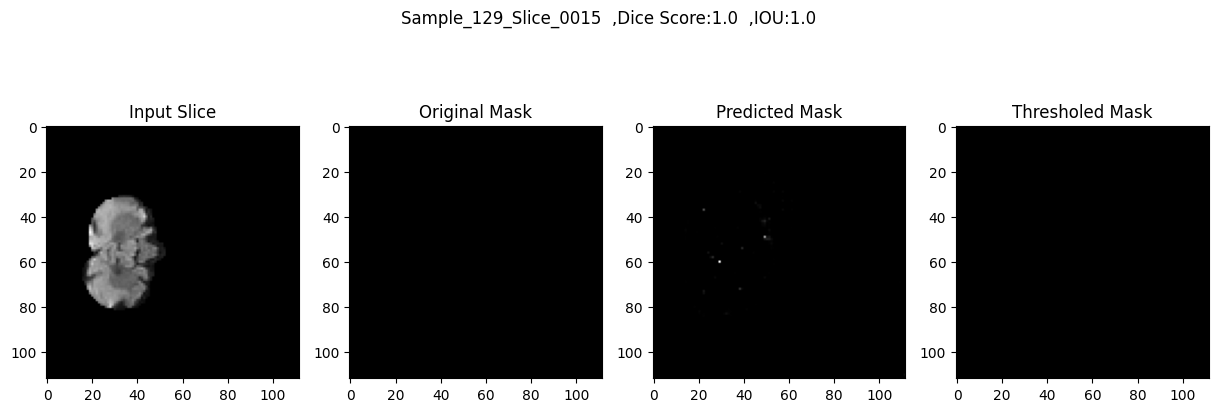

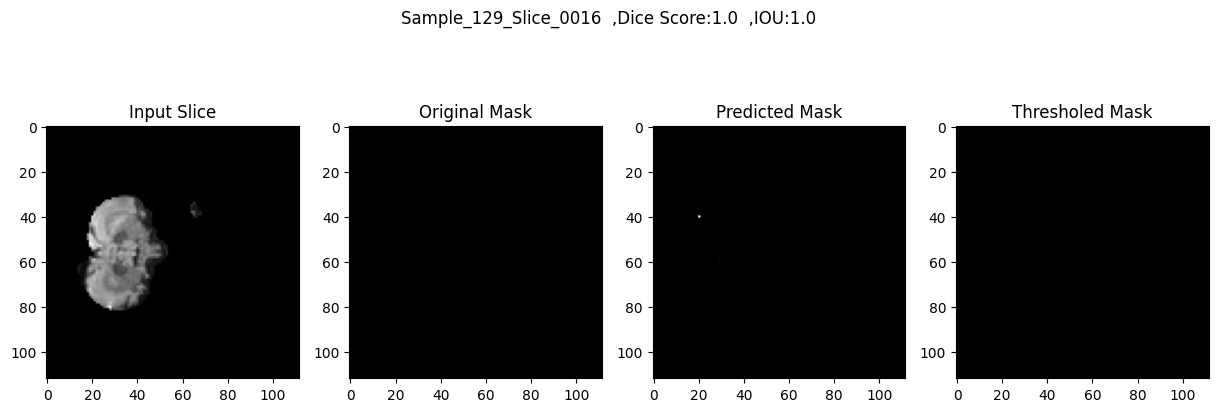

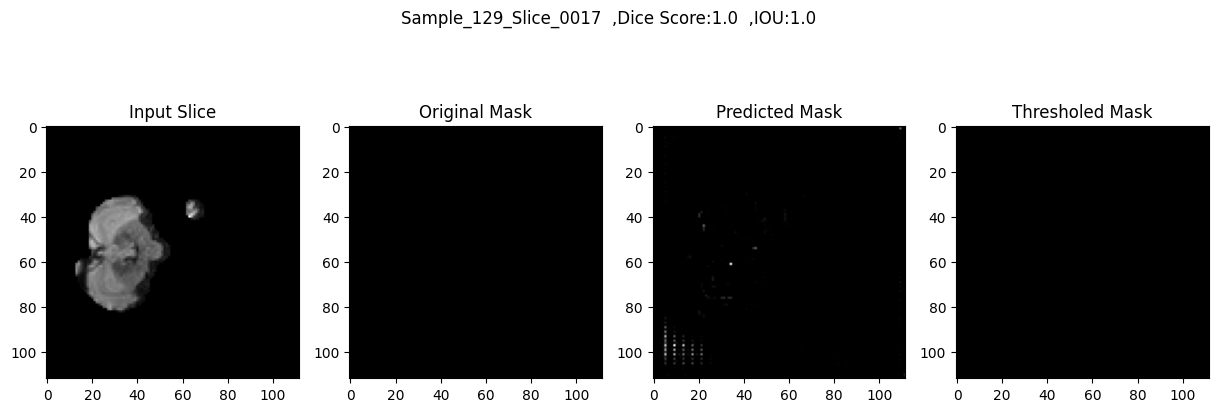

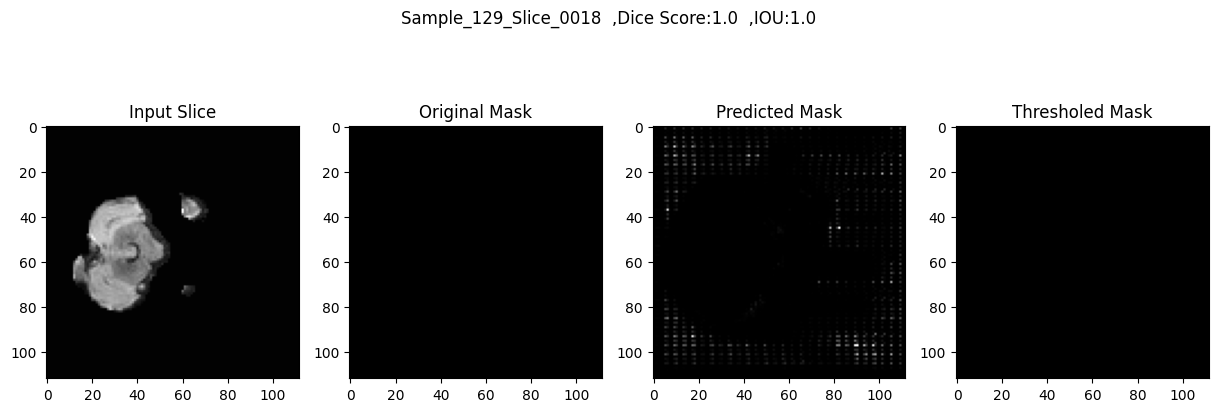

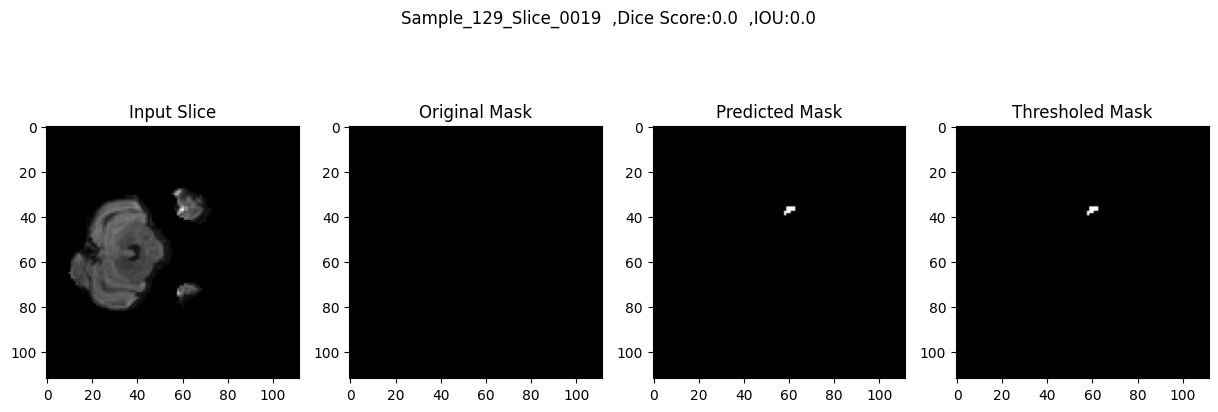

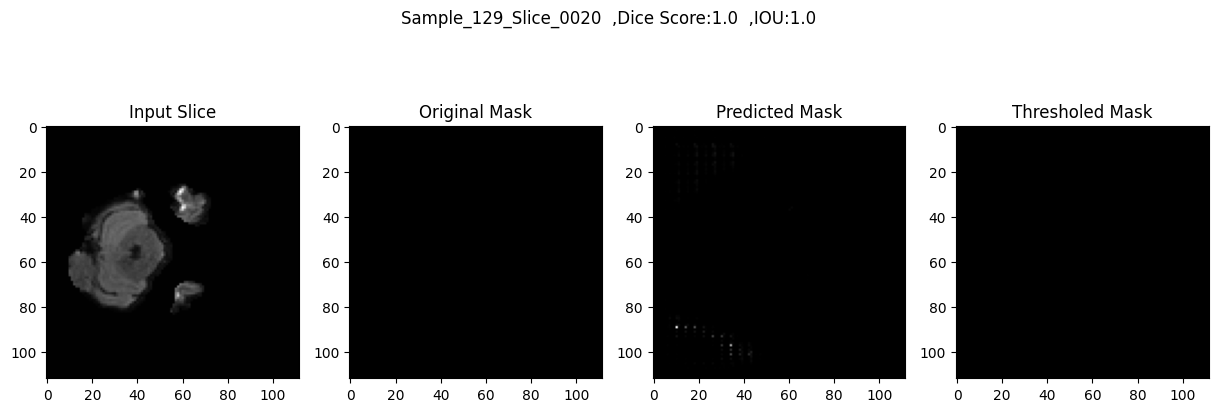

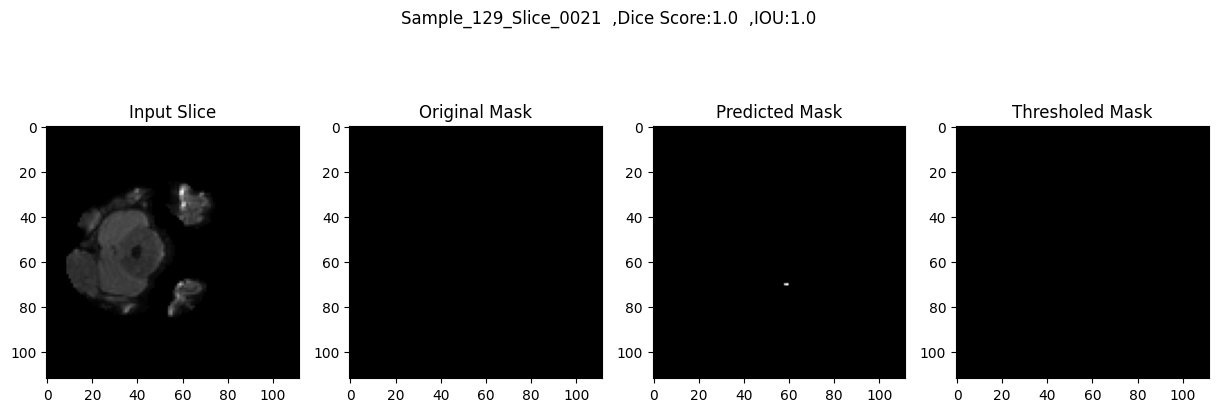

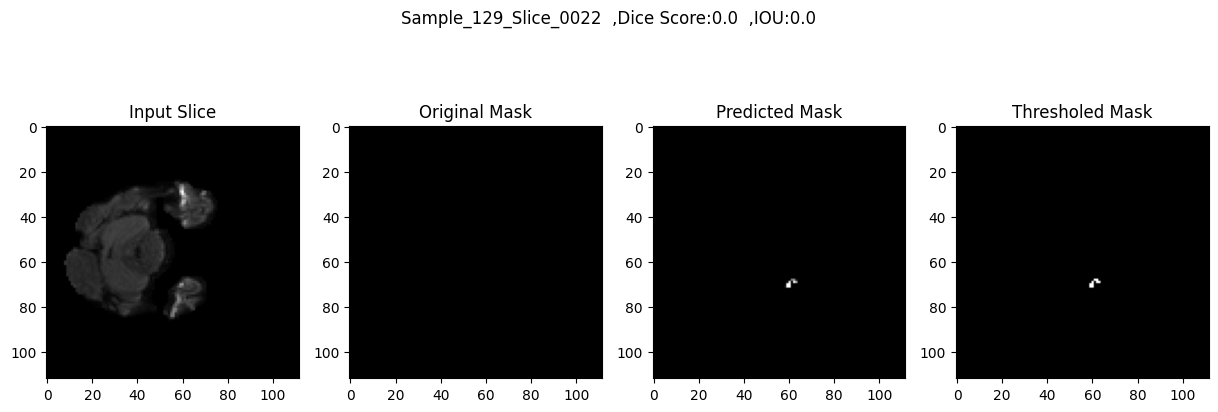

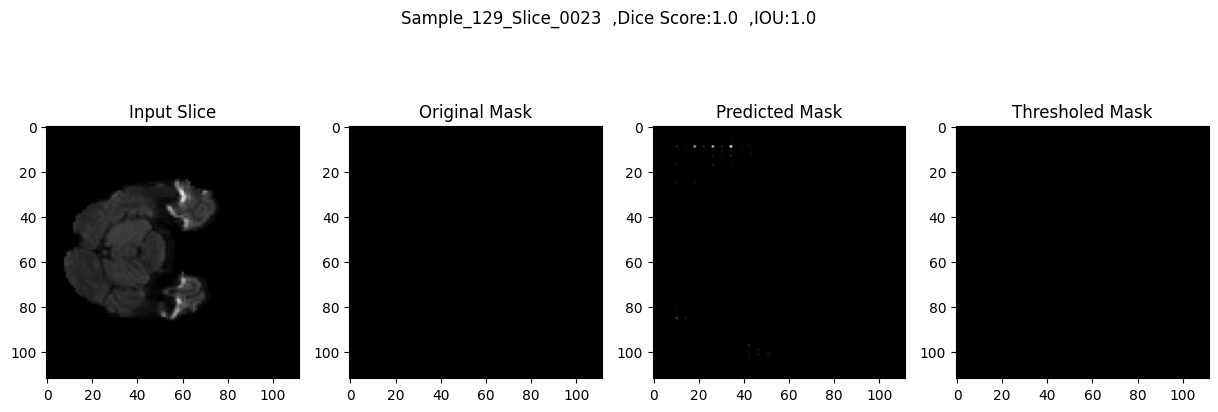

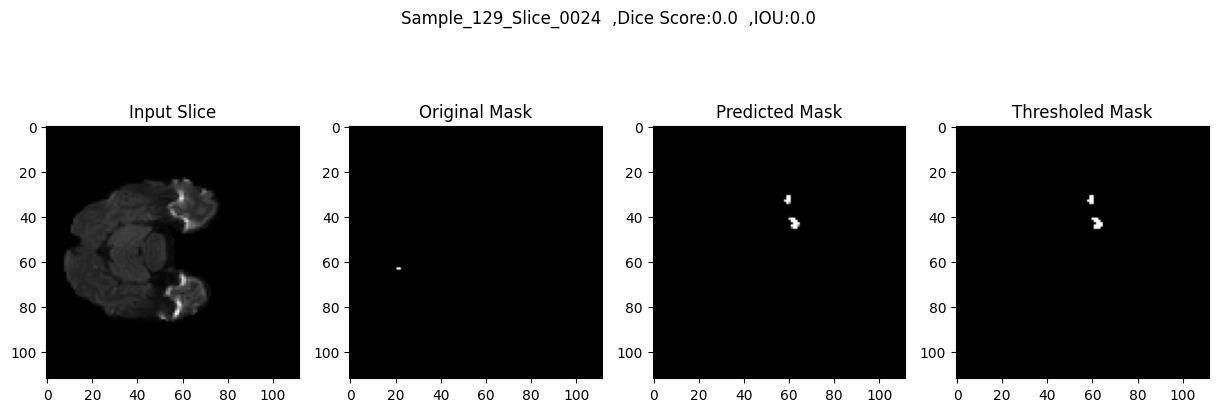

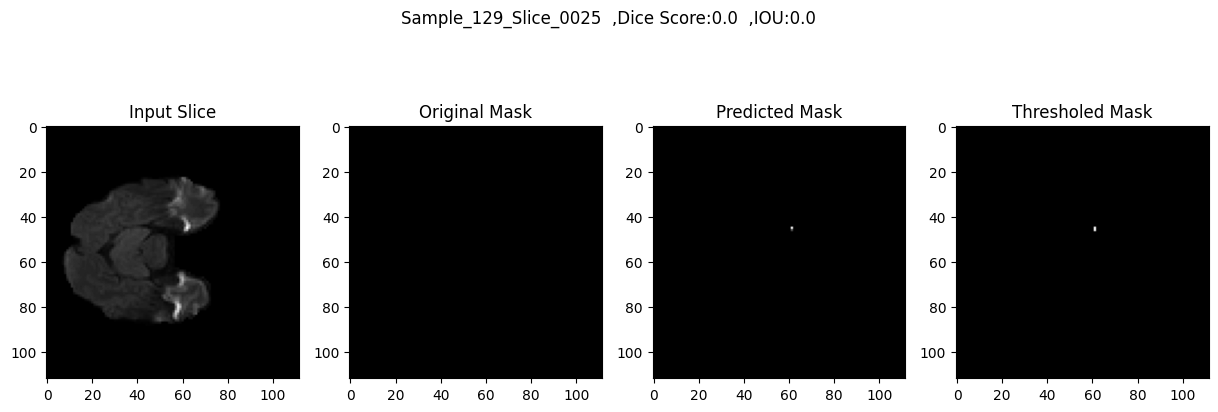

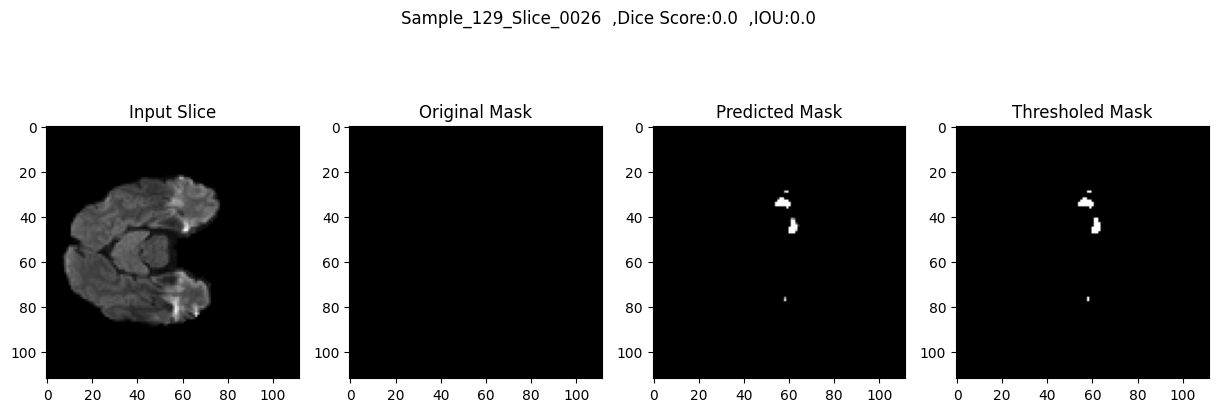

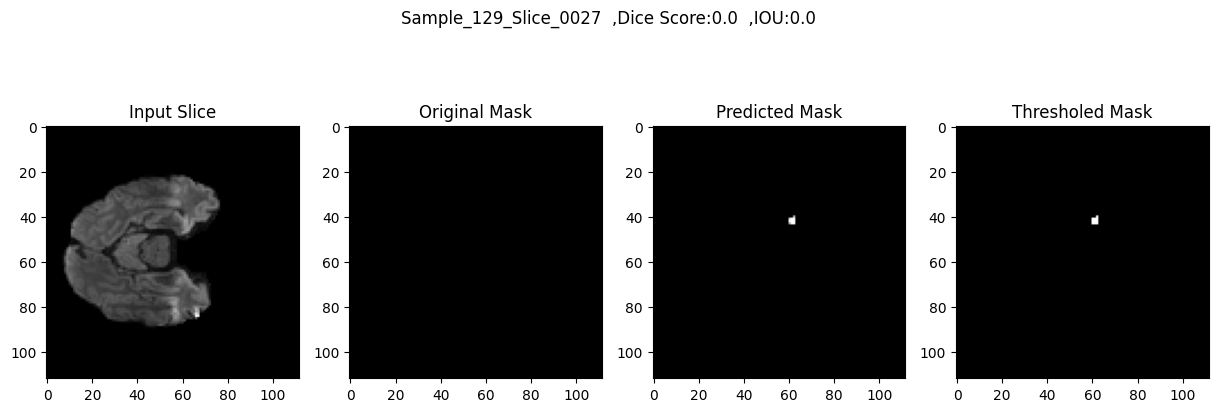

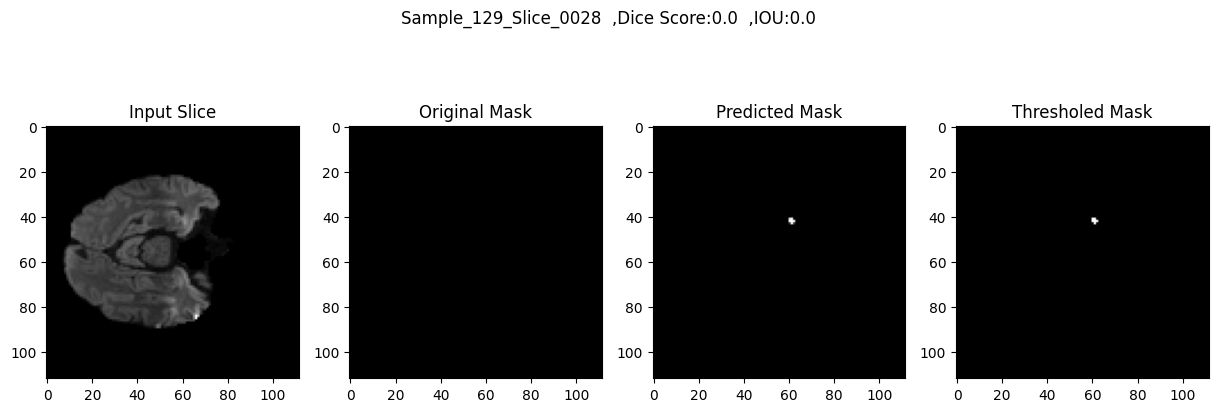

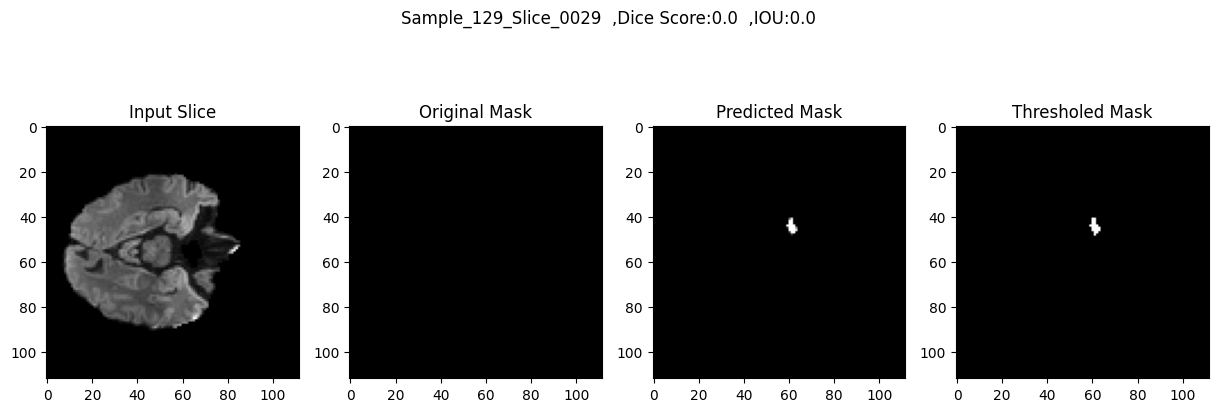

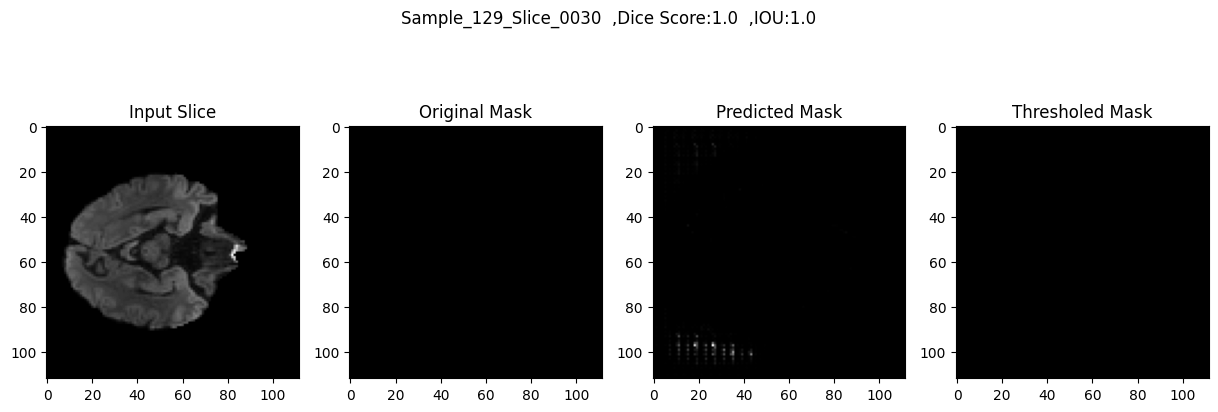

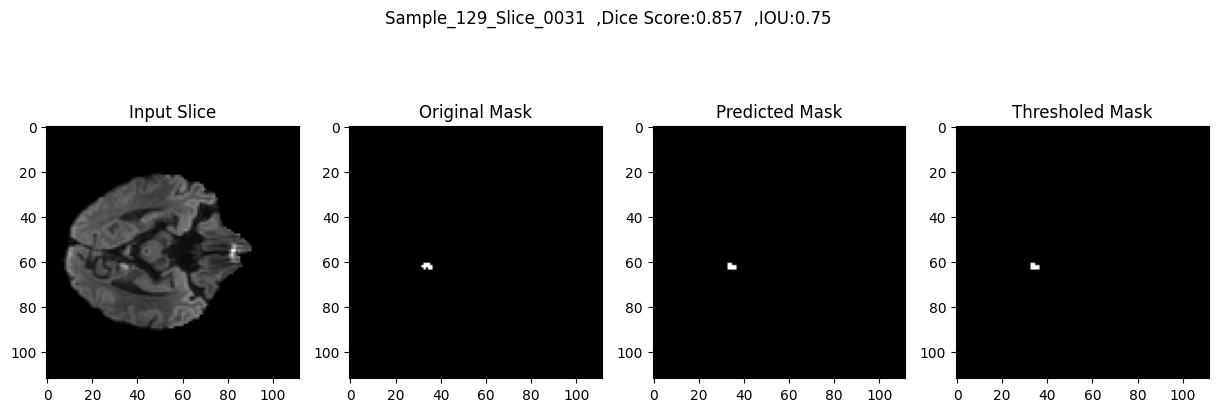

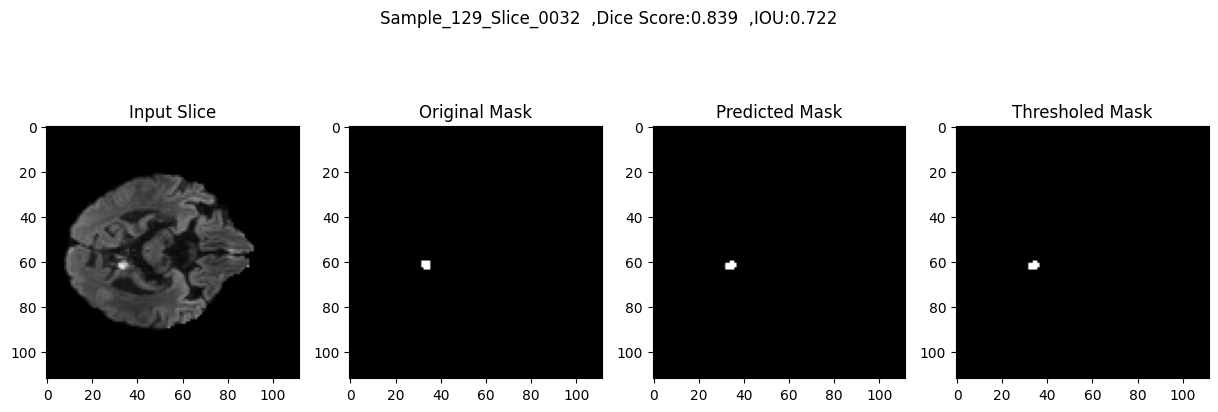

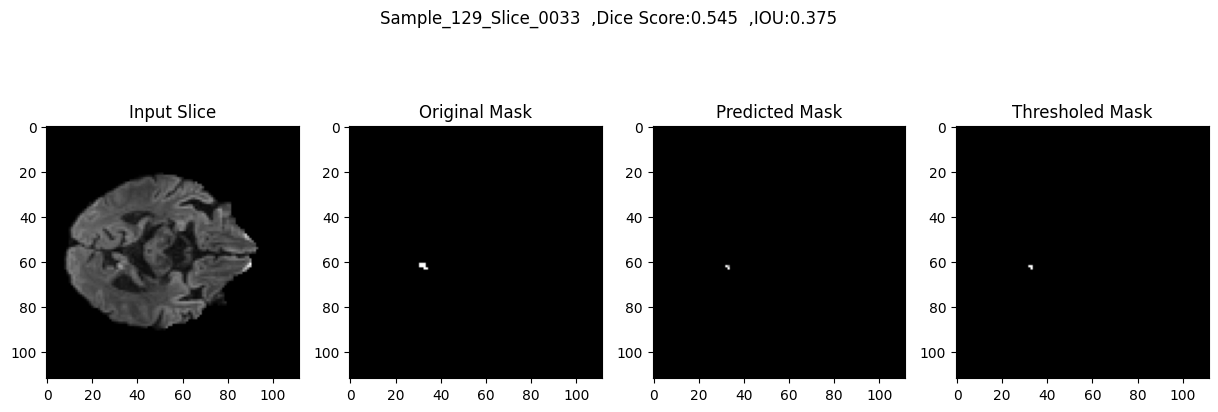

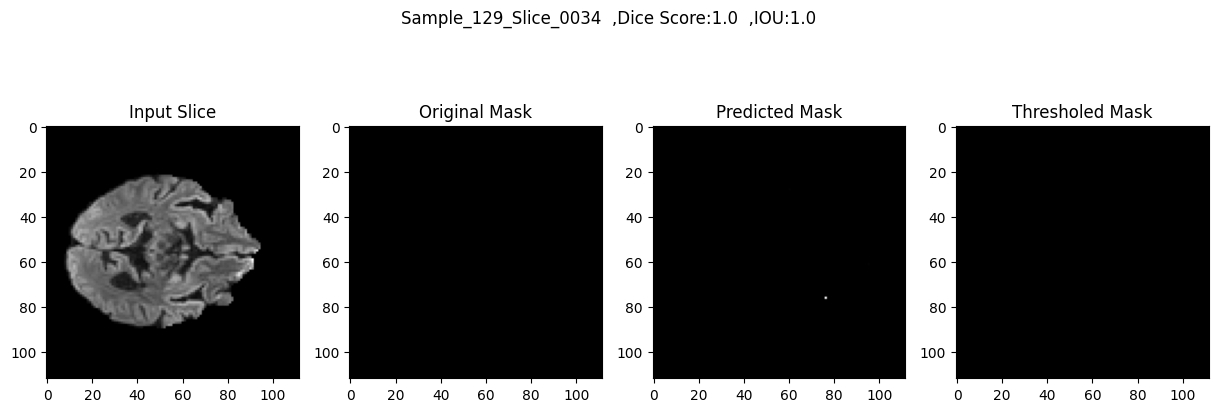

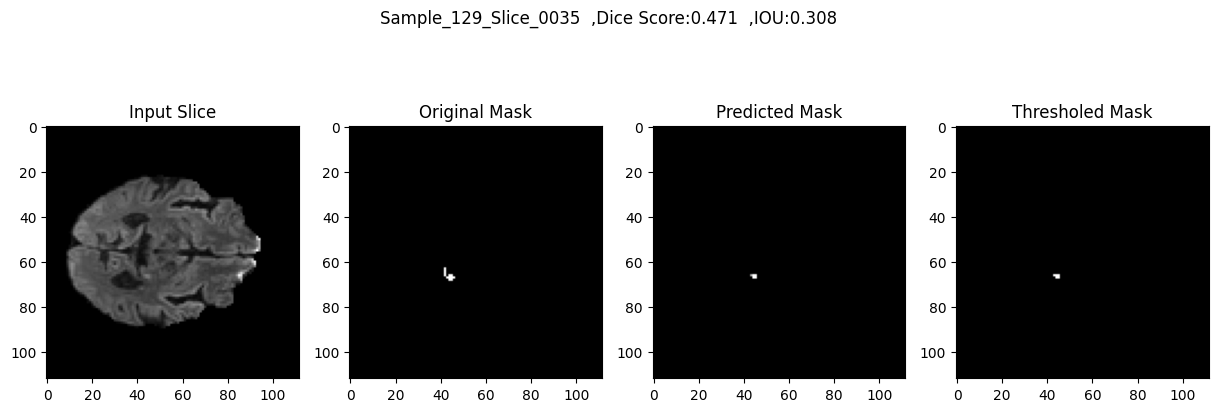

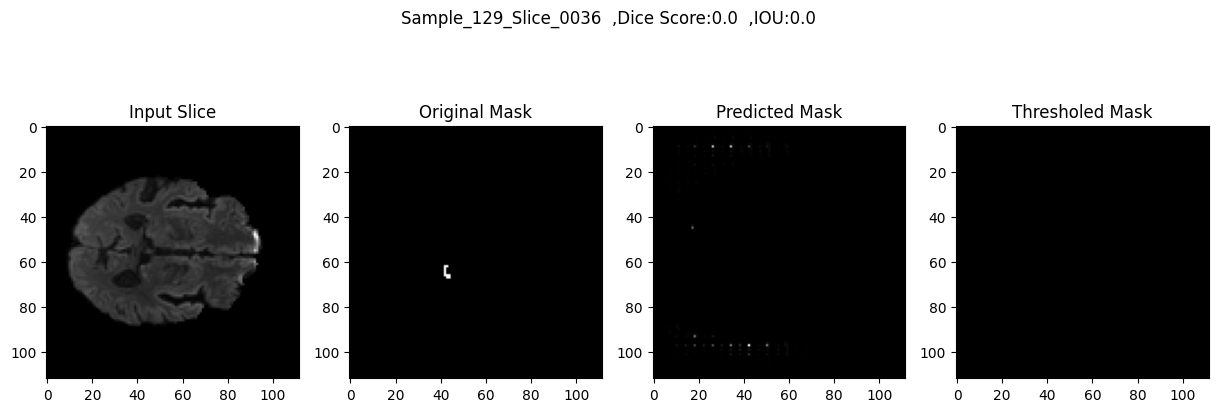

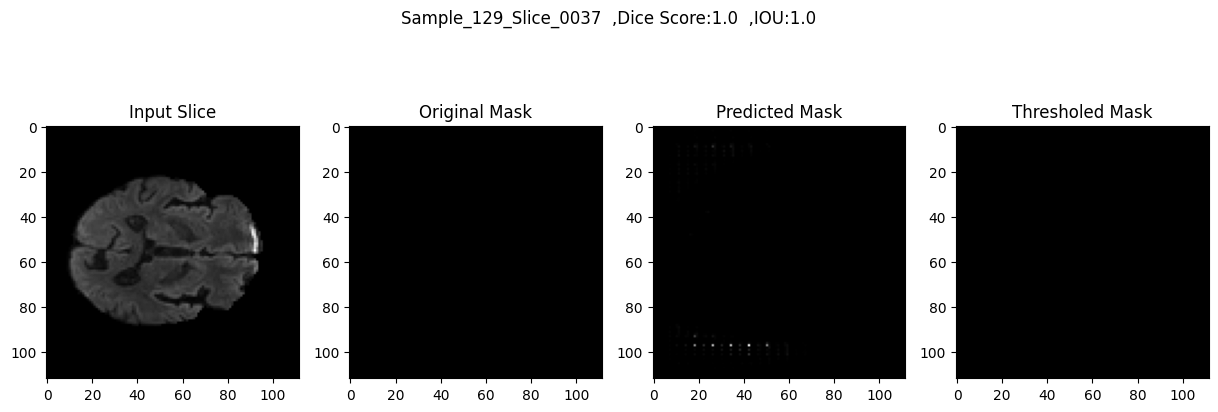

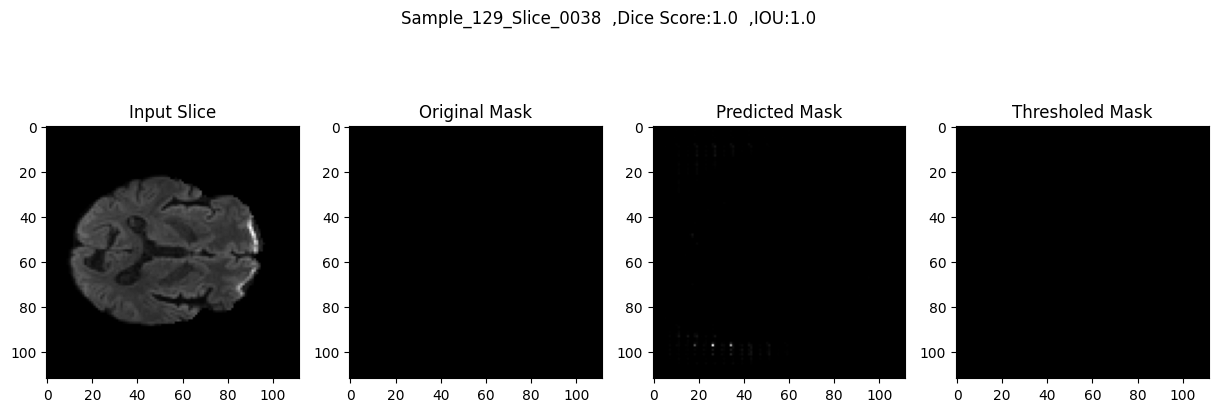

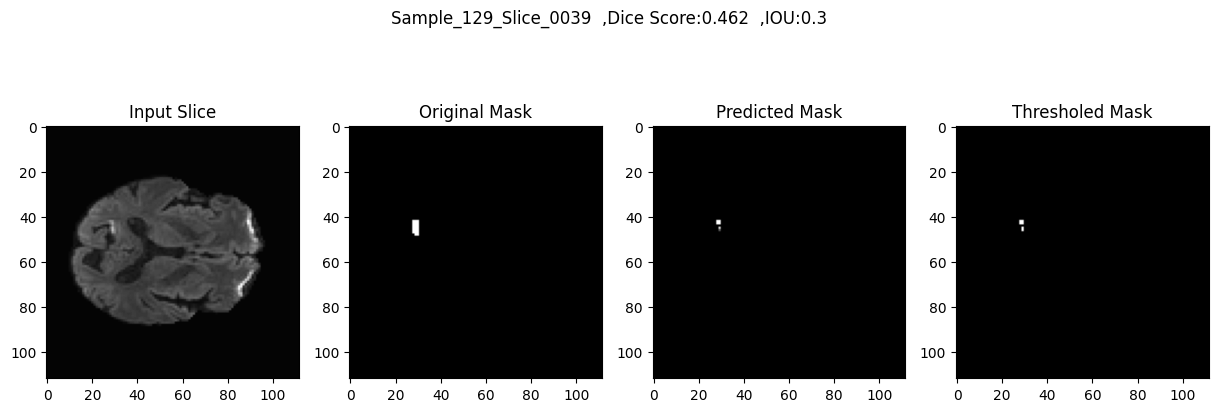

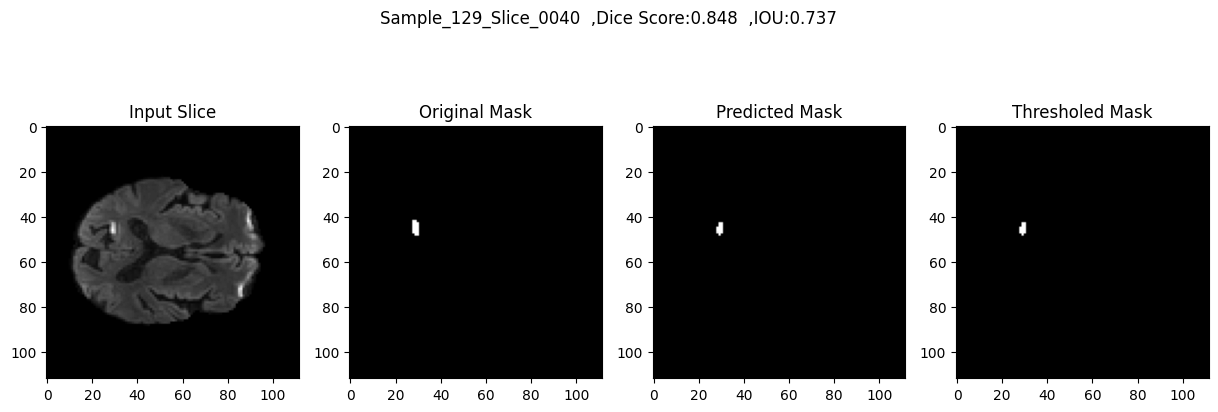

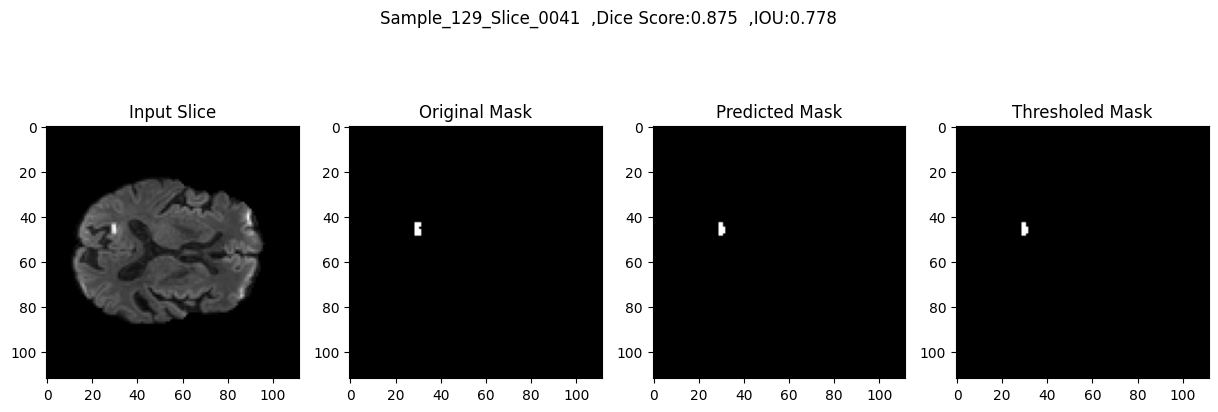

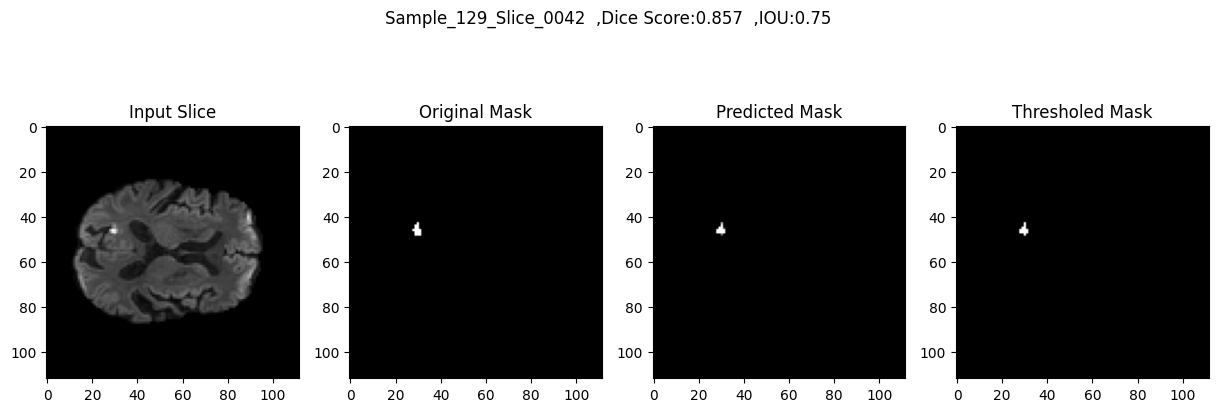

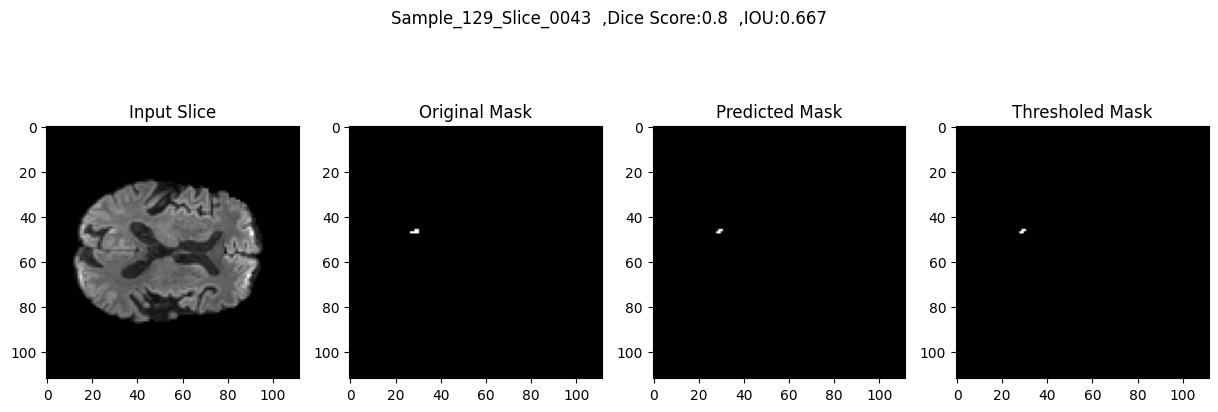

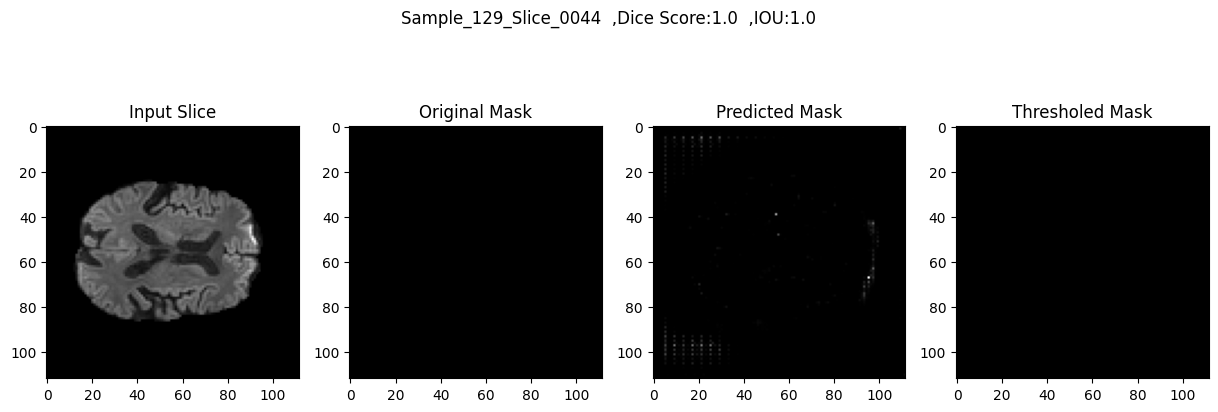

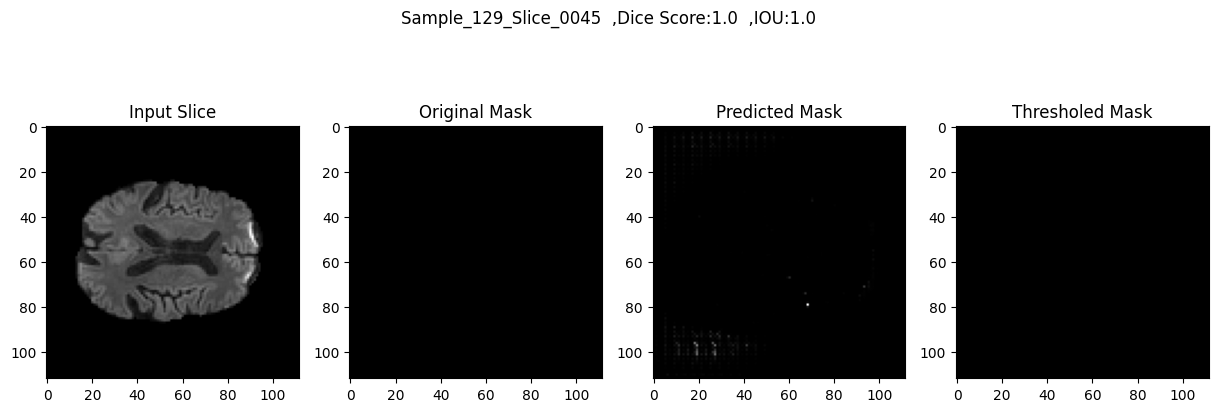

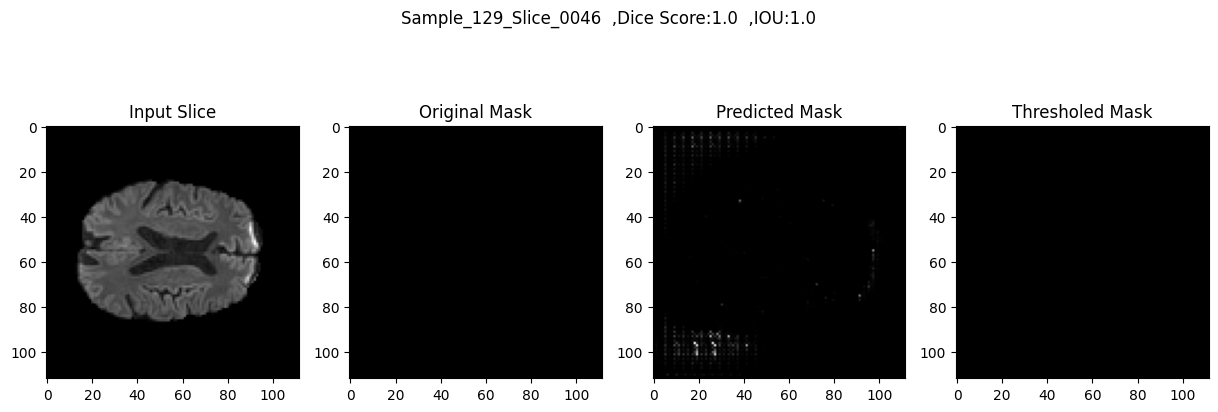

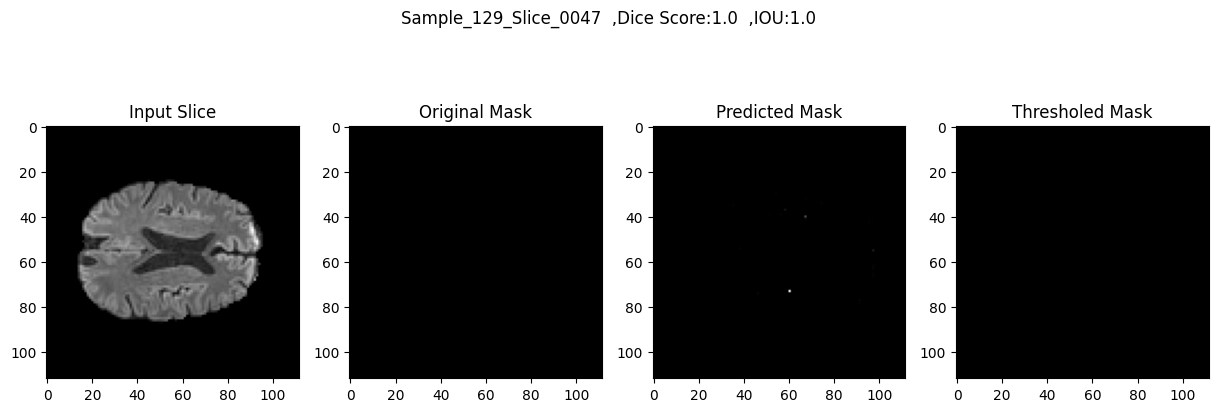

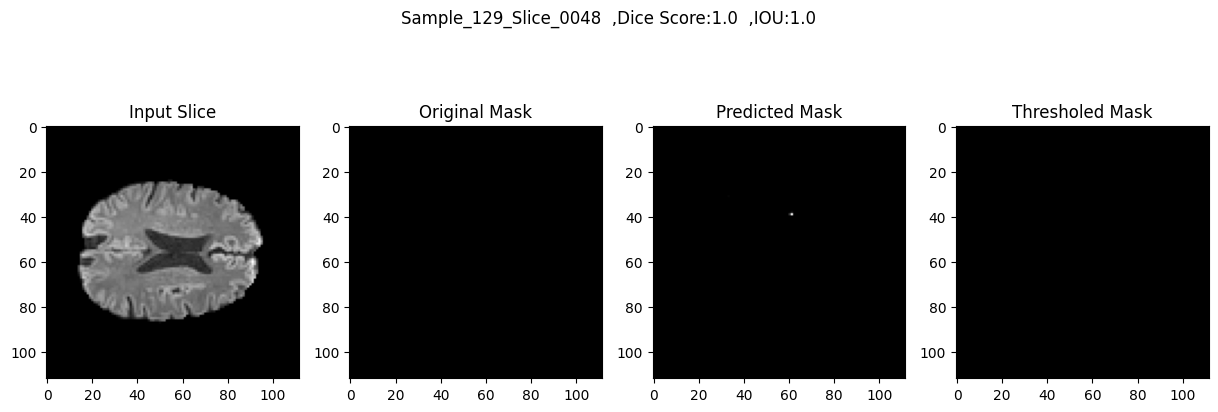

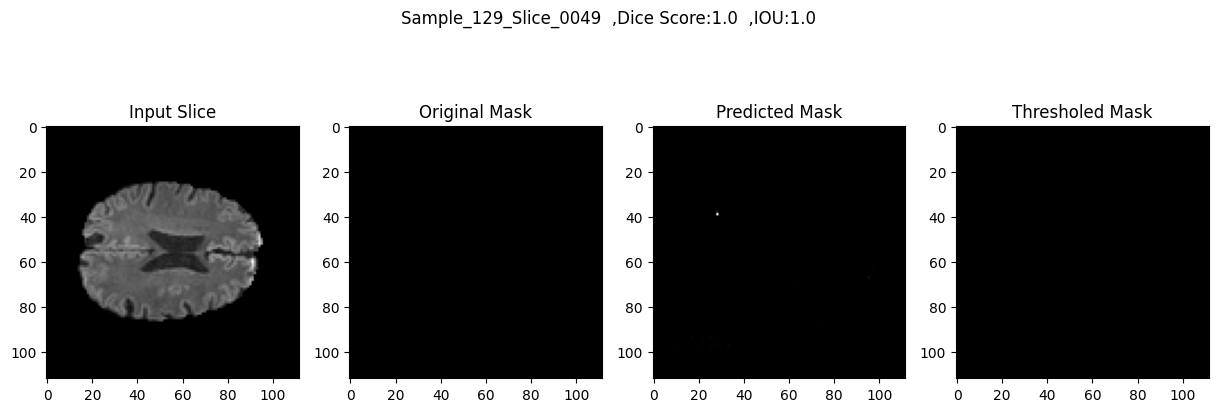

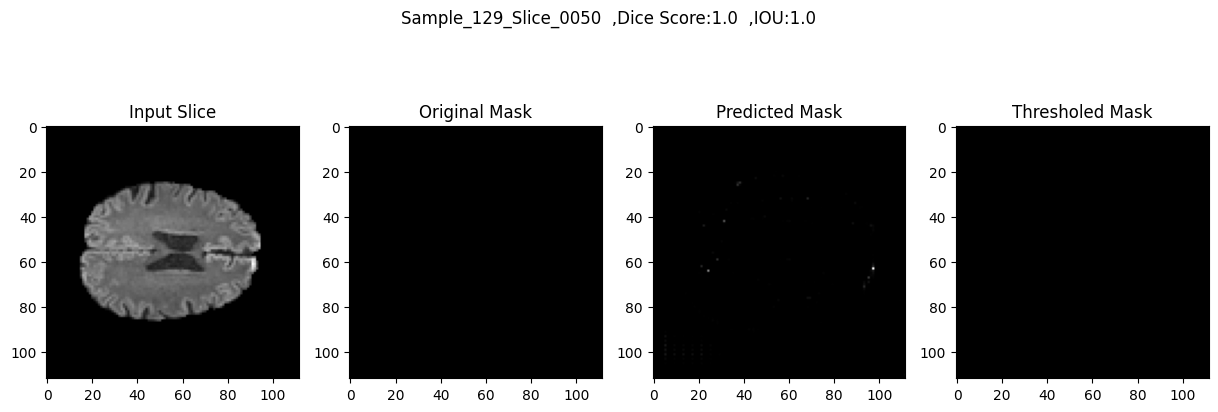

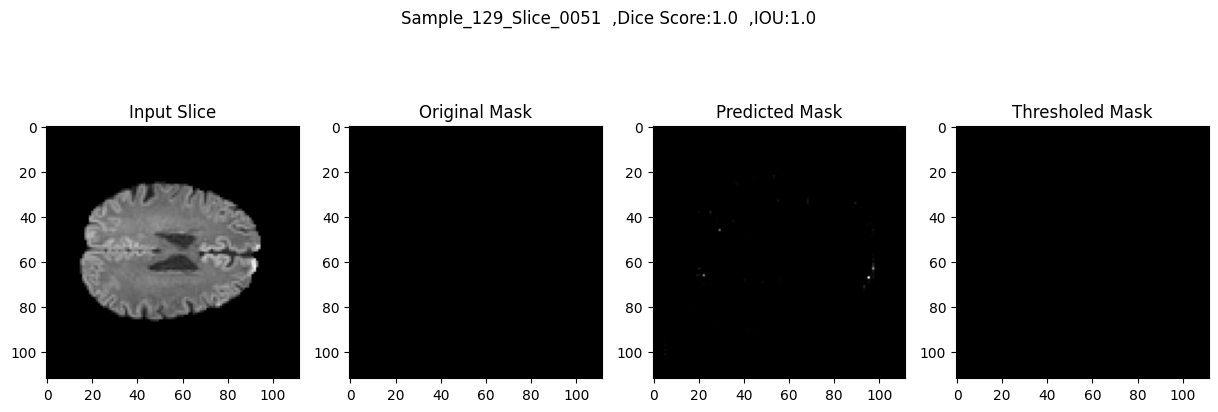

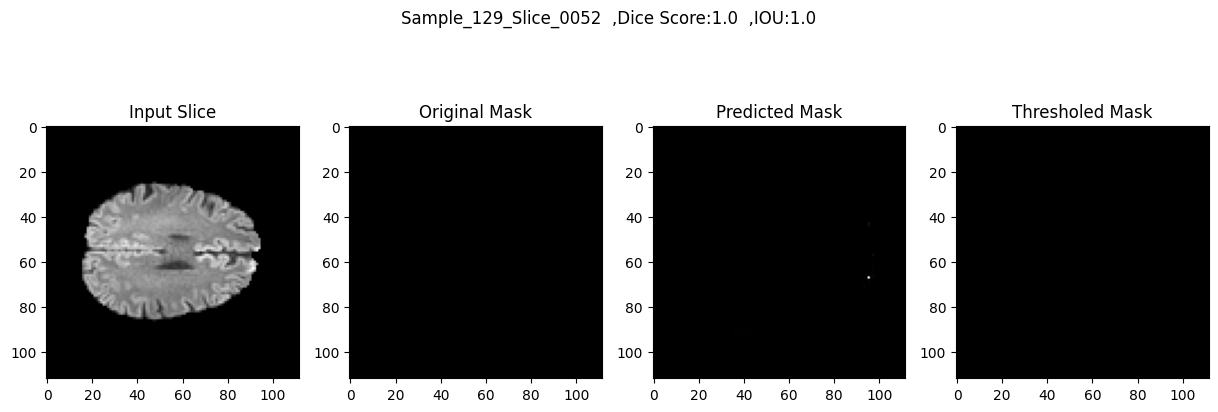

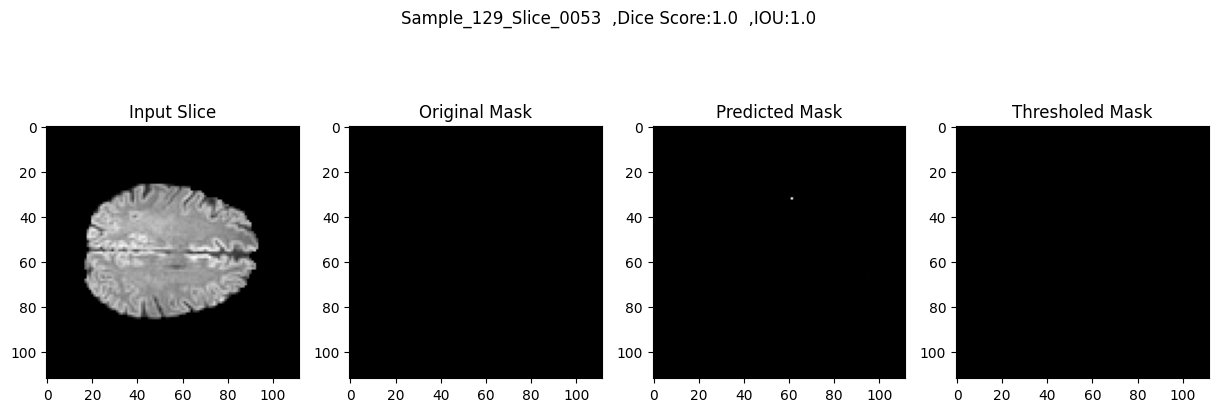

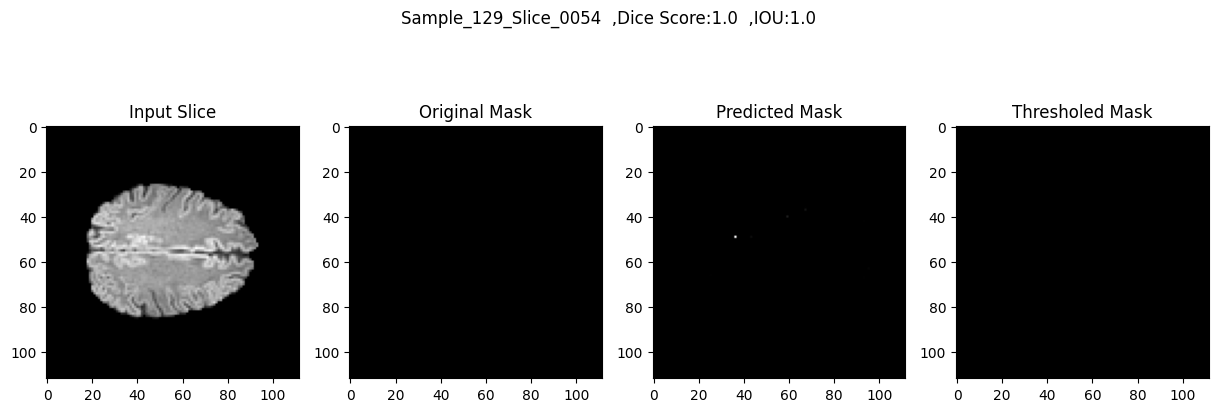

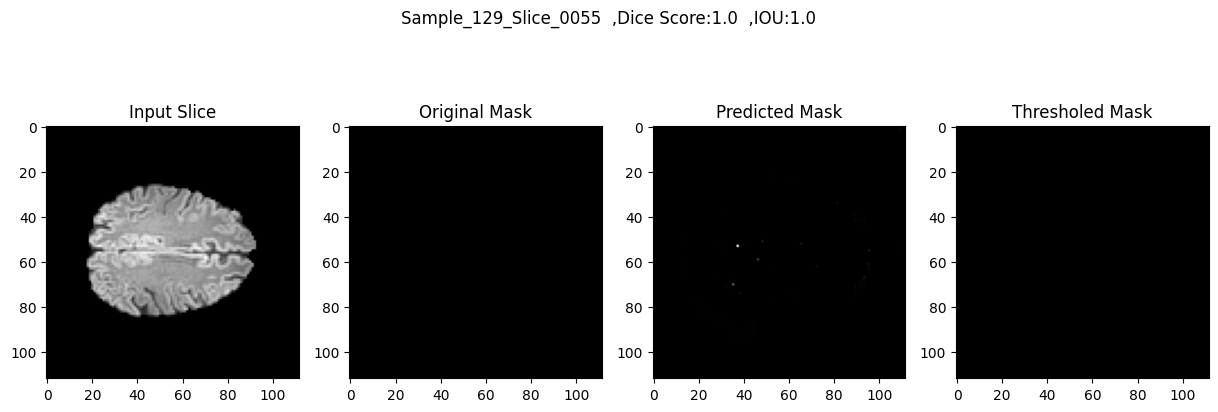

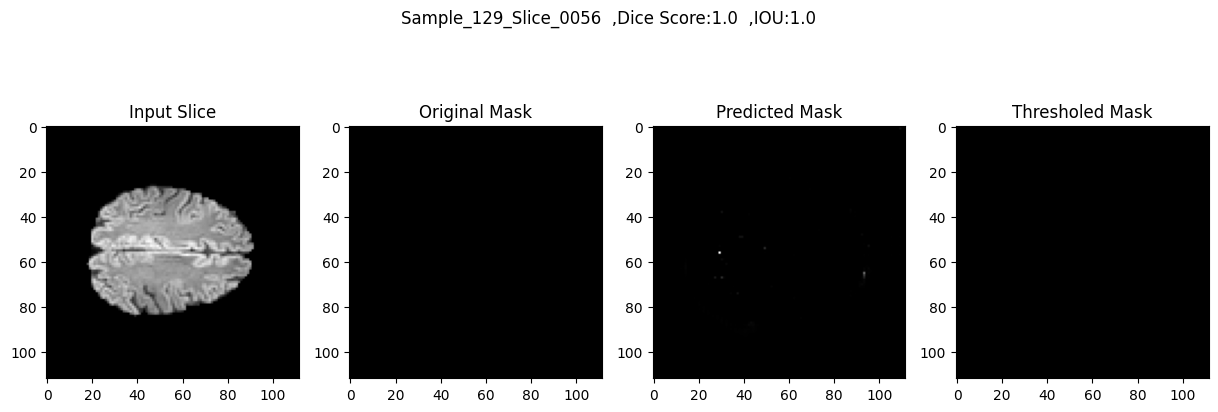

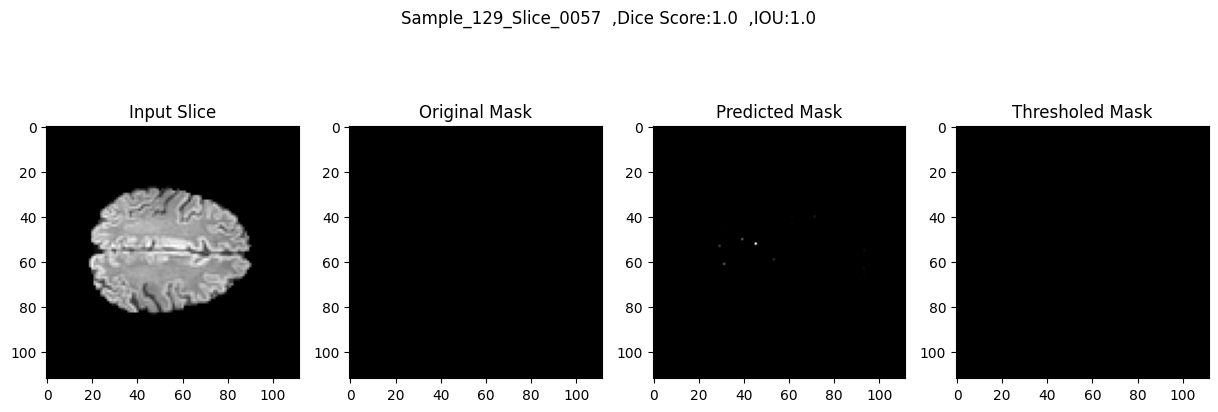

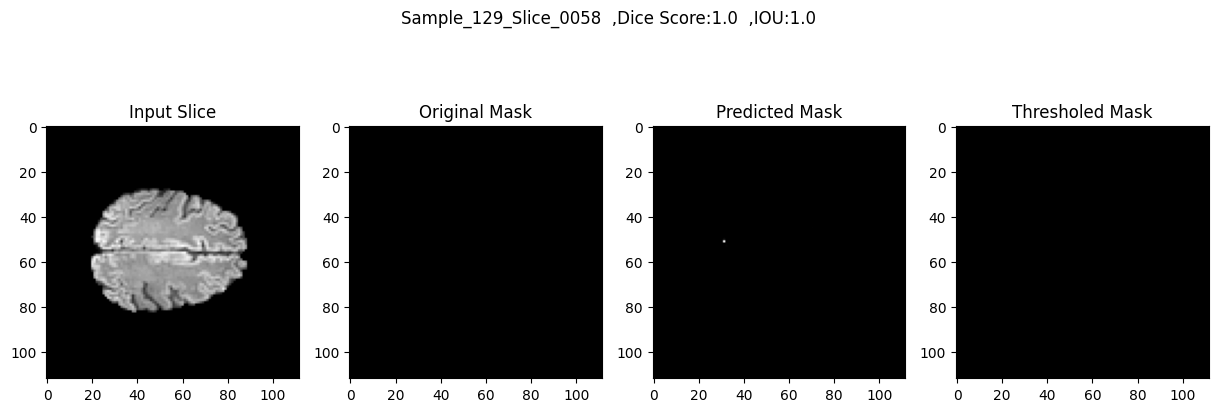

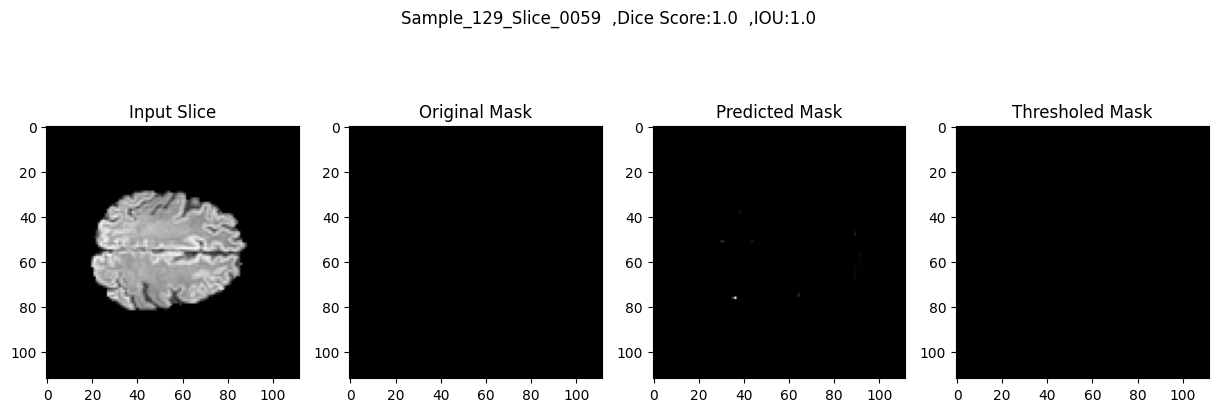

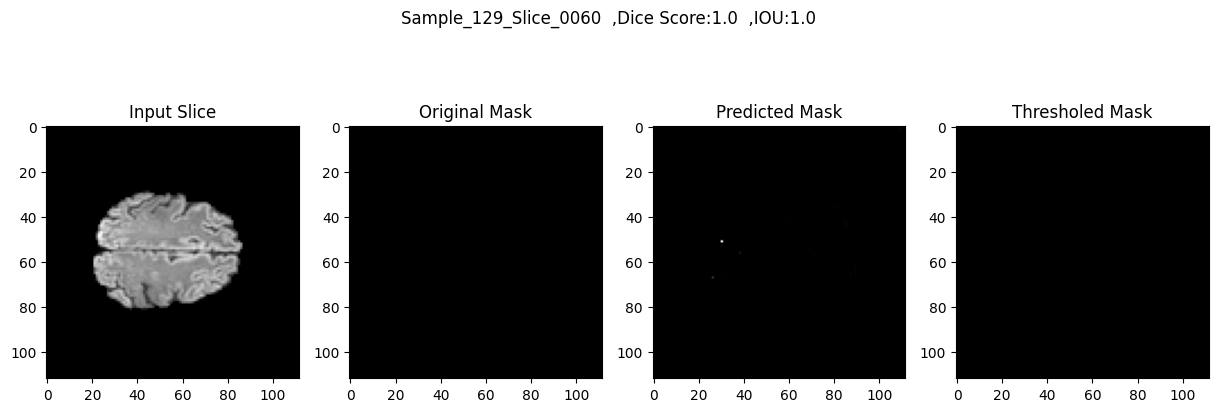

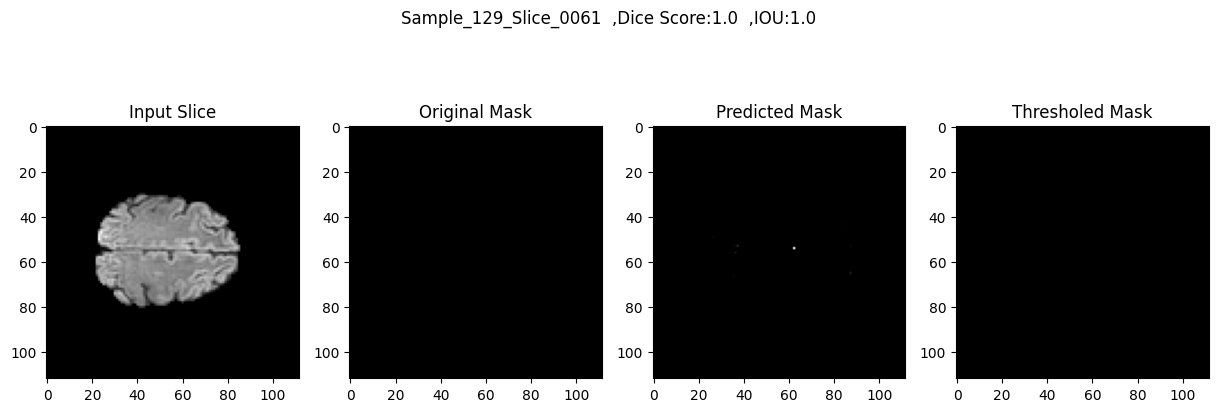

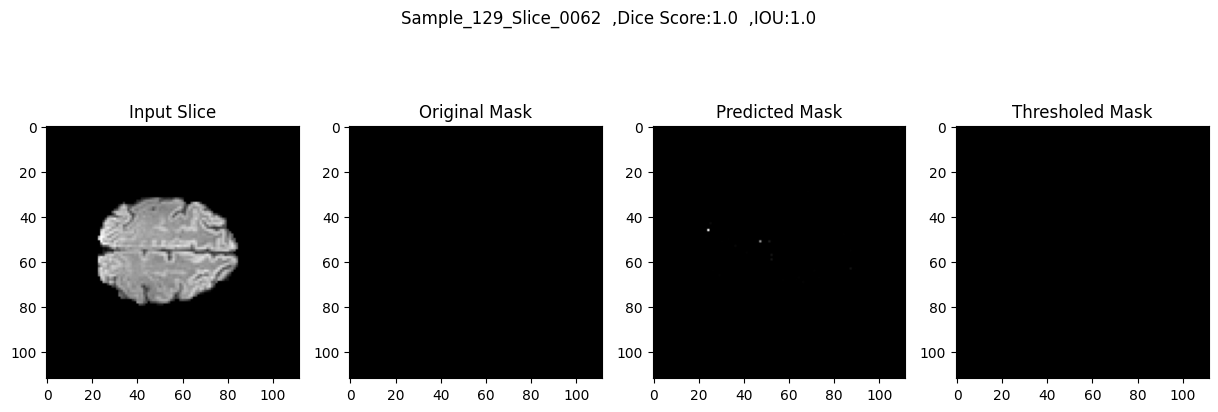

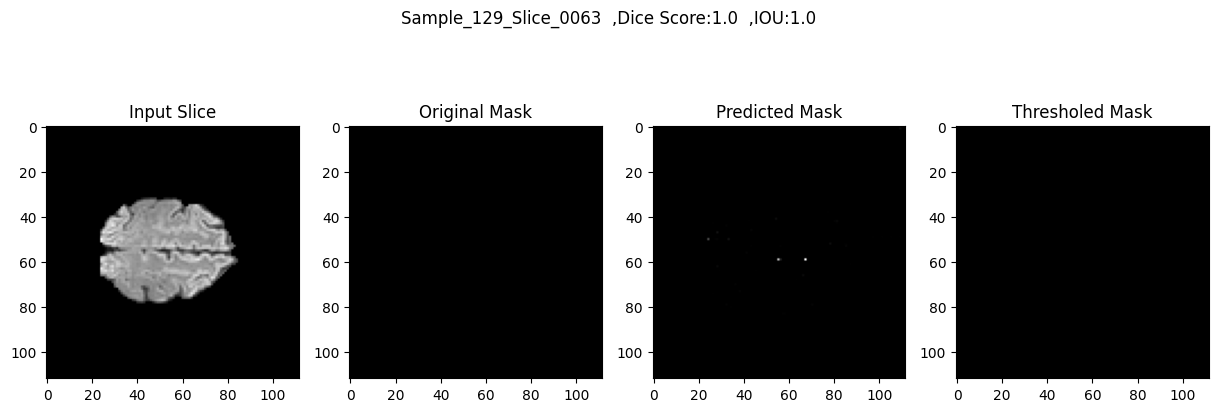

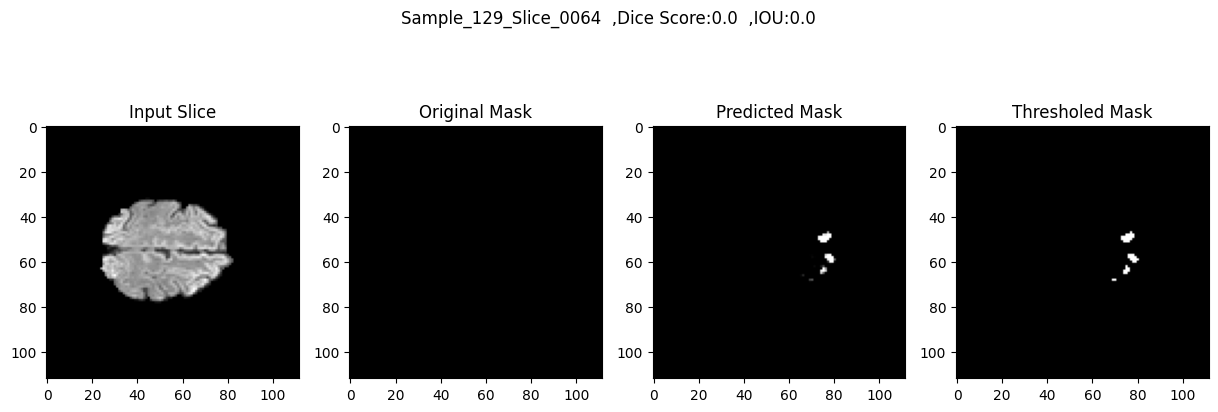

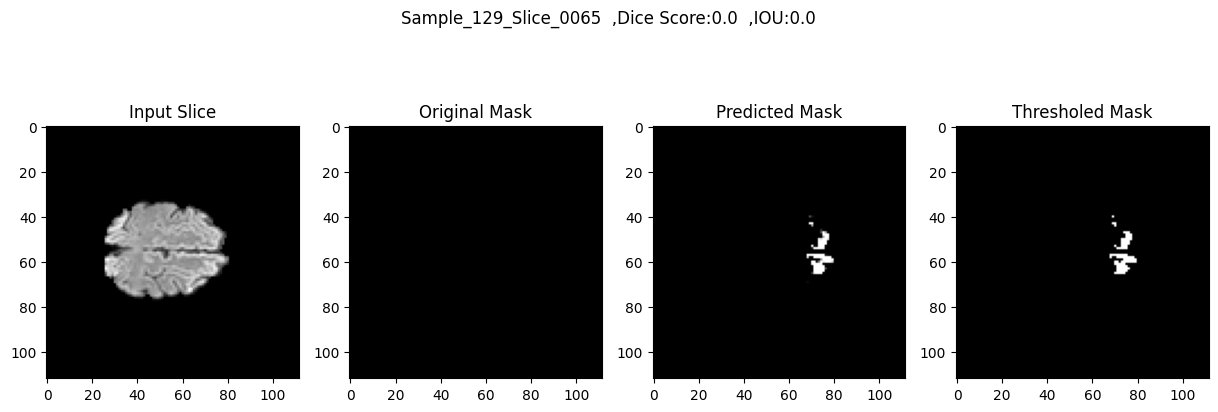

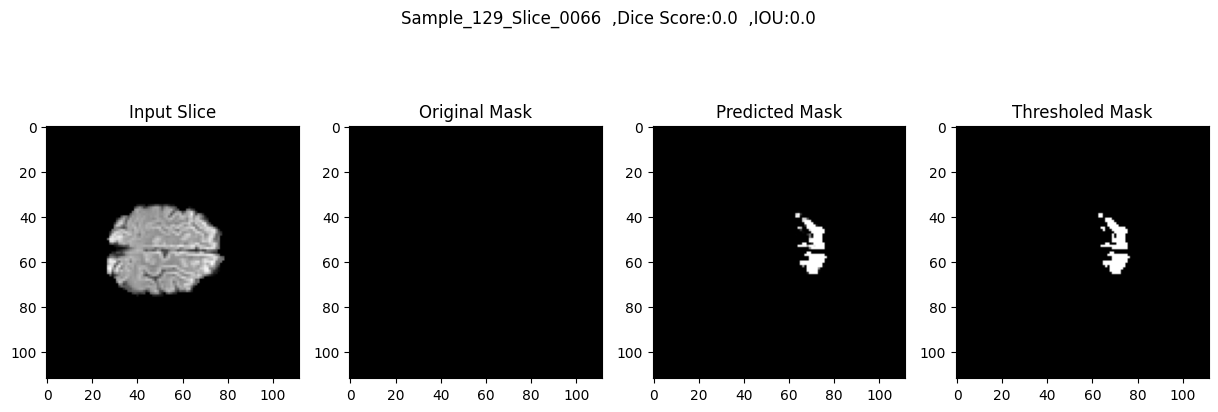

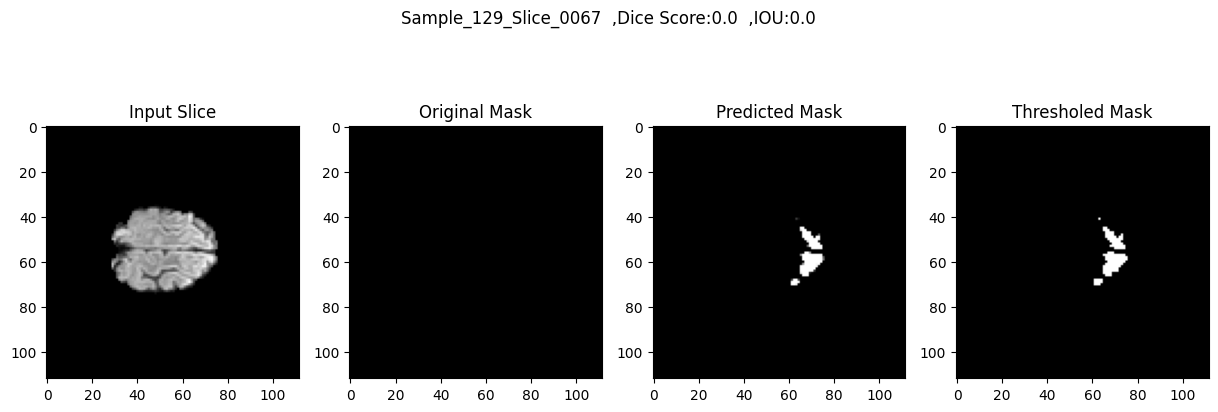

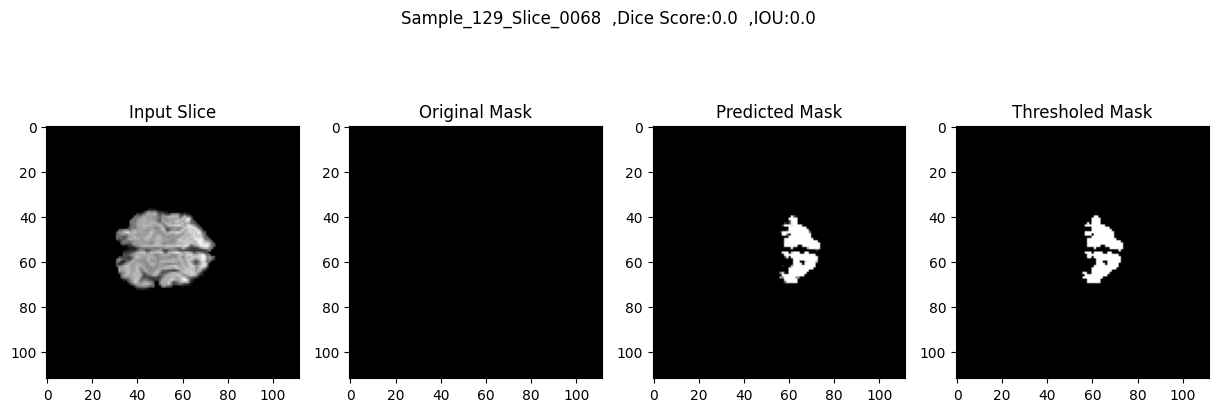

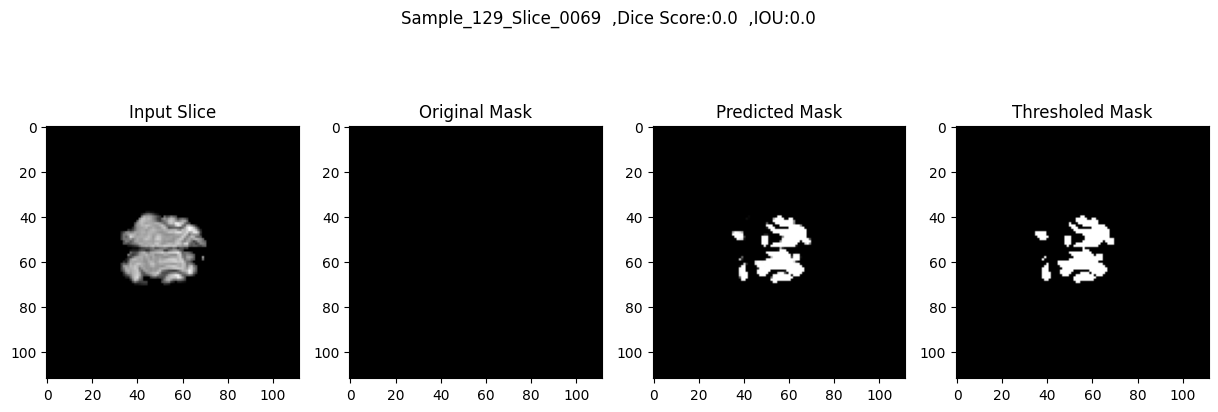

In [25]:
# Specify the directory to save the plot images
#output_directory = "E:\\6thRP_ISLES22_result\\CbamSkip_Dice_AG_Unet7M_ISLES"
#os.makedirs(output_directory, exist_ok=True)

# Plot each slice along with the original mask and predicted mask
for i in range(1,70):
    plt.figure(figsize=(15, 5))

    # Plot the original image
    plt.subplot(1, 4, 1)
    plt.imshow(dwi_image[:,:,i], cmap='gray')
    plt.title('Input Slice')

    # Plot the original mask
    plt.subplot(1, 4, 2)
    plt.imshow(mask_image[:,:,i], cmap='gray')
    plt.title('Original Mask')

    # Plot the predicted mask
    plt.subplot(1, 4, 3)
    plt.imshow(pred_wt[i,:,:,0], cmap='gray')
    plt.title('Predicted Mask')
    
    # Plot the predicted mask
    plt.subplot(1, 4, 4)
    plt.imshow(y_pred_thresholded[i,:,:,0], cmap='gray')
    plt.title('Thresholed Mask')

    #plt.suptitle(f"Slice: {i+1}")
    dice = dice_score(mask_image[:,:,i], y_pred_thresholded[i,:,:,0])
    Iou = iou(mask_image[:,:,i], y_pred_thresholded[i,:,:,0])
    plt.suptitle(f"Sample_129_Slice_00{i}  ,Dice Score:{dice}  ,IOU:{Iou}")
    #print(f'Dice Score: {dice}')
    #plt.savefig(f'plot_{i}.png')
    #plt.show()
        
    # Save the plot image in the output folder
    output_filename = f'Sample_129_Slice_00{i}.png'
    #output_path = os.path.join(output_directory, output_filename)
    #plt.savefig(output_path)
    plt.show()
    plt.close()  # Close the figure to release memory

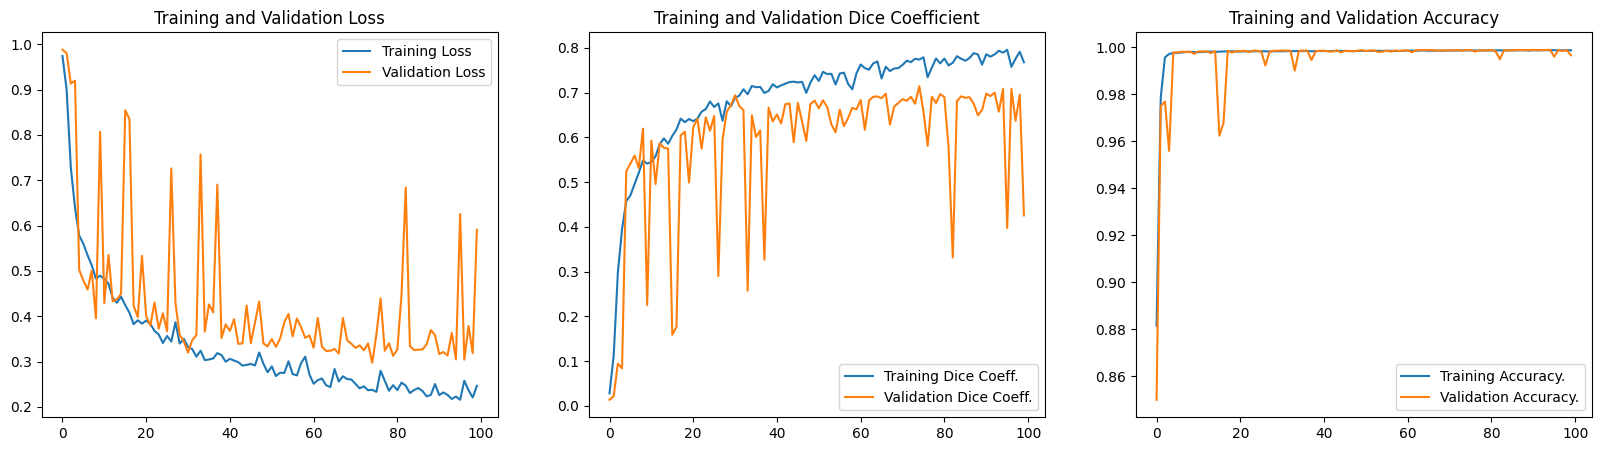

In [27]:
loss = att_unet_history.history['loss']
val_loss = att_unet_history.history['val_loss']

dice = att_unet_history.history['dice_coeff']
val_dice = att_unet_history.history['val_dice_coeff']

acc = att_unet_history.history['accuracy']
val_acc = att_unet_history.history['val_accuracy']

epochs_range = range(100)

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, dice, label='Training Dice Coeff.')
plt.plot(epochs_range, val_dice, label='Validation Dice Coeff.')
plt.legend(loc='best')
plt.title('Training and Validation Dice Coefficient')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, acc, label='Training Accuracy.')
plt.plot(epochs_range, val_acc, label='Validation Accuracy.')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.show()